In [1]:
# Standard libraries
import os
import sys
import json
import random
import logging
import numpy as np
import matplotlib.pyplot as plt

# Third-party libraries
from tqdm import tqdm
from torchsummary import summary

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

# PyTorch learning rate schedulers
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# PyTorch utilities
from torchvision.utils import make_grid

# Project-specific modules
from autoencoder.autoencoder import *
from PARCv1.differentiator import *
from PARCtorch.integrator.rk4 import *
from PARCtorch.integrator.numintegrator import *
from LatentPARC_model import *
from model_analysis import *

ModuleNotFoundError: No module named 'geometry'

##### To Update version of PARCtorch

download file below from github, upload to home directory, then run code below

!pip install /home/pdy2bw/PARCtorch-0.3.0-py3-none-any.whl

# Load in Data Paths and Functions

In [2]:
# get PARCtorch path
path = os.path.abspath(os.path.join(os.getcwd(), "..")) 
print(path)

# Add the root directory (PARCTorch) to the system path
sys.path.append(path)
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth
from data.normalization import compute_min_max

# Get single void HMX data
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path

# Path to the min_max.json file
min_max_path = os.path.join(path, "data", "hmx_min_max.json")  # Correct path

/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch
Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC
Total files to process: 91
Processed 91/91 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, 0.0, 0.0]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7200.339, 7200.339]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


# Create Data Loader for Training

In [3]:
n_ts = 2 # do 2 for single ts (1 future ts which is target)
batch_size = 32
validation_split = 0.05  # 5% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-05-23 09:33:59,087 [INFO] Starting data validation...
2025-05-23 09:33:59,092 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:00<00:00, 344.32it/s]
2025-05-23 09:33:59,388 [INFO] Data validation completed successfully.
2025-05-23 09:33:59,389 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 491.30it/s]
2025-05-23 09:33:59,597 [INFO] Total samples in dataset: 1400


#### Reshape Testing

In [4]:
# n_channels = 3
# for images in tqdm(train_loader, desc="Training"):
#     # optimizer.zero_grad()
#     ic, _, ts, target = images # ts is number of ts - 1
#     ic, target = ic[:, :n_channels, ...], target[:, :, :n_channels, ...]
#     break     

# Define LatentPARC Architecture + Training

In [3]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC"
weights_name="IRCAE_test"

# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 8]
latent_dim = 8
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

NameError: name 'Encoder' is not defined

In [ ]:
# ONLY RUN IF LOADING PRETRAINED WEIGHTS TO AE
# !!!! If this works, modify AE code to save encoder and decoder weights separate for simplicity
AE_weights_path = "autoencoder/2_layers_and_latent_experiment/layers_3_8_latent_8_DE_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_3000.pth"
ckpt = torch.load(AE_weights_path, map_location=device)

encoder.load_state_dict({k.replace('encoder.', ''): v for k, v in ckpt.items() if k.startswith('encoder.')})
decoder.load_state_dict({k.replace('decoder.', ''): v for k, v in ckpt.items() if k.startswith('decoder.')})

##################
## OPTIONAL: freeze AE weights
for param in encoder.parameters():
    param.requires_grad = False

for param in decoder.parameters():
    param.requires_grad = False

####################

In [8]:
# Initialize LatentPARC
model_init = lp_model(encoder, decoder, differentiator, integrator).to(device)

#Loss Function
criterion = torch.nn.L1Loss().to(device)
# criterion = LpLoss(p=10).cuda()
# criterion = nn.MSELoss()

optimizer = Adam(model_init.parameters(), lr=1e-3)

# Define learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True)

#  training model
model = LatentPARC(model_init, optimizer, save_path, weights_name)

log_dict = model.train(criterion, epochs=100, image_size = [128, 256], n_channels=3, device=device, 
                       train_loader=train_loader, val_loader=val_loader, scheduler=scheduler,
                       noise_fn=add_random_noise, initial_max_noise=0.16, n_reduce_factor=0.5, 
                       ms_reduce_factor=0, reduce_on=3, mode="single_ts_train")


Epoch 1/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


Epoch 1: Training Loss: 0.1203 | Validation Loss: 0.1015

Epoch 2/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


Epoch 2: Training Loss: 0.1020 | Validation Loss: 0.0968

Epoch 3/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


Epoch 3: Training Loss: 0.0752 | Validation Loss: 0.0715

Epoch 4/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch 4: Training Loss: 0.0596 | Validation Loss: 0.0665

Epoch 5/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Epoch 5: Training Loss: 0.0573 | Validation Loss: 0.0693

Epoch 6/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Epoch 6: Training Loss: 0.0507 | Validation Loss: 0.0532

Epoch 7/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Epoch 7: Training Loss: 0.0469 | Validation Loss: 0.0507

Epoch 8/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


Epoch 8: Training Loss: 0.0445 | Validation Loss: 0.0444

Epoch 9/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch 9: Training Loss: 0.0402 | Validation Loss: 0.0366

Epoch 10/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 10: Training Loss: 0.0388 | Validation Loss: 0.0378

Epoch 11/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s]


Epoch 11: Training Loss: 0.0393 | Validation Loss: 0.0380

Epoch 12/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch 12: Training Loss: 0.0375 | Validation Loss: 0.0343

Epoch 13/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]


Epoch 13: Training Loss: 0.0390 | Validation Loss: 0.0339

Epoch 14/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch 14: Training Loss: 0.0357 | Validation Loss: 0.0323

Epoch 15/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


Epoch 15: Training Loss: 0.0344 | Validation Loss: 0.0340

Epoch 16/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


Epoch 16: Training Loss: 0.0390 | Validation Loss: 0.0313

Epoch 17/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch 17: Training Loss: 0.0354 | Validation Loss: 0.0333

Epoch 18/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]


Epoch 18: Training Loss: 0.0346 | Validation Loss: 0.0375

Epoch 19/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch 19: Training Loss: 0.0358 | Validation Loss: 0.0398

Epoch 20/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


Epoch 20: Training Loss: 0.0365 | Validation Loss: 0.0298

Epoch 21/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


Epoch 21: Training Loss: 0.0327 | Validation Loss: 0.0329

Epoch 22/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]


Epoch 22: Training Loss: 0.0367 | Validation Loss: 0.0366

Epoch 23/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s]


Epoch 23: Training Loss: 0.0346 | Validation Loss: 0.0298

Epoch 24/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


Epoch 24: Training Loss: 0.0310 | Validation Loss: 0.0311

Epoch 25/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


Epoch 25: Training Loss: 0.0321 | Validation Loss: 0.0347

Epoch 26/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 26: Training Loss: 0.0329 | Validation Loss: 0.0291

Epoch 27/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.81it/s]


Epoch 27: Training Loss: 0.0306 | Validation Loss: 0.0282

Epoch 28/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch 28: Training Loss: 0.0321 | Validation Loss: 0.0302

Epoch 29/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


Epoch 29: Training Loss: 0.0305 | Validation Loss: 0.0253

Epoch 30/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


Epoch 30: Training Loss: 0.0277 | Validation Loss: 0.0251

Epoch 31/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


Epoch 31: Training Loss: 0.0262 | Validation Loss: 0.0269

Epoch 32/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch 32: Training Loss: 0.0276 | Validation Loss: 0.0265

Epoch 33/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


Epoch 33: Training Loss: 0.0278 | Validation Loss: 0.0292

Epoch 34/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch 34: Training Loss: 0.0270 | Validation Loss: 0.0265

Epoch 35/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


Epoch 35: Training Loss: 0.0268 | Validation Loss: 0.0252

Epoch 36/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


Epoch 36: Training Loss: 0.0255 | Validation Loss: 0.0262

Epoch 37/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


Epoch 37: Training Loss: 0.0266 | Validation Loss: 0.0253

Epoch 38/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 38: Training Loss: 0.0248 | Validation Loss: 0.0241

Epoch 39/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


Epoch 39: Training Loss: 0.0286 | Validation Loss: 0.0279

Epoch 40/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch 40: Training Loss: 0.0265 | Validation Loss: 0.0280

Epoch 41/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s]


Epoch 41: Training Loss: 0.0262 | Validation Loss: 0.0262

Epoch 42/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch 42: Training Loss: 0.0256 | Validation Loss: 0.0232

Epoch 43/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Epoch 43: Training Loss: 0.0245 | Validation Loss: 0.0238

Epoch 44/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]


Epoch 44: Training Loss: 0.0243 | Validation Loss: 0.0235

Epoch 45/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


Epoch 45: Training Loss: 0.0258 | Validation Loss: 0.0242

Epoch 46/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]


Epoch 46: Training Loss: 0.0246 | Validation Loss: 0.0267

Epoch 47/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch 47: Training Loss: 0.0251 | Validation Loss: 0.0214

Epoch 48/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s]


Epoch 48: Training Loss: 0.0249 | Validation Loss: 0.0267

Epoch 49/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 49: Training Loss: 0.0262 | Validation Loss: 0.0250

Epoch 50/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch 50: Training Loss: 0.0246 | Validation Loss: 0.0286

Epoch 51/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch 51: Training Loss: 0.0265 | Validation Loss: 0.0218

Epoch 52/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s]


Epoch 52: Training Loss: 0.0253 | Validation Loss: 0.0232

Epoch 53/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


Epoch 53: Training Loss: 0.0240 | Validation Loss: 0.0256

Epoch 54/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


Epoch 54: Training Loss: 0.0243 | Validation Loss: 0.0252

Epoch 55/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch 55: Training Loss: 0.0241 | Validation Loss: 0.0224

Epoch 56/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Epoch 56: Training Loss: 0.0242 | Validation Loss: 0.0249

Epoch 57/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.28it/s]


Epoch 57: Training Loss: 0.0233 | Validation Loss: 0.0236

Epoch 58/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


Epoch 58: Training Loss: 0.0237 | Validation Loss: 0.0256

Epoch 59/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


Epoch 59: Training Loss: 0.0223 | Validation Loss: 0.0221

Epoch 60/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Epoch 60: Training Loss: 0.0223 | Validation Loss: 0.0209

Epoch 61/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch 61: Training Loss: 0.0237 | Validation Loss: 0.0198

Epoch 62/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


Epoch 62: Training Loss: 0.0217 | Validation Loss: 0.0212

Epoch 63/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


Epoch 63: Training Loss: 0.0237 | Validation Loss: 0.0266

Epoch 64/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch 64: Training Loss: 0.0233 | Validation Loss: 0.0240

Epoch 65/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


Epoch 65: Training Loss: 0.0246 | Validation Loss: 0.0275

Epoch 66/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


Epoch 66: Training Loss: 0.0224 | Validation Loss: 0.0219

Epoch 67/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


Epoch 67: Training Loss: 0.0220 | Validation Loss: 0.0231

Epoch 68/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch 68: Training Loss: 0.0230 | Validation Loss: 0.0194

Epoch 69/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


Epoch 69: Training Loss: 0.0215 | Validation Loss: 0.0242

Epoch 70/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


Epoch 70: Training Loss: 0.0225 | Validation Loss: 0.0209

Epoch 71/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch 71: Training Loss: 0.0211 | Validation Loss: 0.0214

Epoch 72/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


Epoch 72: Training Loss: 0.0221 | Validation Loss: 0.0201

Epoch 73/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch 73: Training Loss: 0.0206 | Validation Loss: 0.0195

Epoch 74/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


Epoch 74: Training Loss: 0.0226 | Validation Loss: 0.0221

Epoch 75/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]


Epoch 75: Training Loss: 0.0230 | Validation Loss: 0.0214

Epoch 76/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Epoch 76: Training Loss: 0.0250 | Validation Loss: 0.0267

Epoch 77/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


Epoch 77: Training Loss: 0.0259 | Validation Loss: 0.0277

Epoch 78/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 78: Training Loss: 0.0224 | Validation Loss: 0.0189

Epoch 79/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch 79: Training Loss: 0.0208 | Validation Loss: 0.0229

Epoch 80/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch 80: Training Loss: 0.0202 | Validation Loss: 0.0211

Epoch 81/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


Epoch 81: Training Loss: 0.0205 | Validation Loss: 0.0216

Epoch 82/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch 82: Training Loss: 0.0219 | Validation Loss: 0.0229

Epoch 83/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]


Epoch 83: Training Loss: 0.0227 | Validation Loss: 0.0202

Epoch 84/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


Epoch 84: Training Loss: 0.0203 | Validation Loss: 0.0212

Epoch 85/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]


Epoch 85: Training Loss: 0.0201 | Validation Loss: 0.0185

Epoch 86/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


Epoch 86: Training Loss: 0.0201 | Validation Loss: 0.0190

Epoch 87/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


Epoch 87: Training Loss: 0.0192 | Validation Loss: 0.0206

Epoch 88/100


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch 88: Training Loss: 0.0210 | Validation Loss: 0.0208

Epoch 89/100


Training:  45%|████▌     | 19/42 [00:03<00:03,  6.30it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_839195/2096714253.py", line 18, in <module>
    log_dict = model.train(criterion, epochs=100, image_size = [128, 256], n_channels=3, device=device,
  File "/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/LatentPARC_model.py", line 454, in train
    return train_latentparc(self.network, self.optimizer, loss_function, train_loader, val_loader,
  File "/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/LatentPARC_model.py", line 358, in train_latentparc
    train_losses.append(loss.item())
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactives

# Load in weights

In [6]:
# define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize all elements
layer_sizes = [3, 8]
latent_dim = 8
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

# Initialize LatentPARC
model_init = lp_model(encoder, decoder, differentiator, integrator).to(device)

# Init Optimizer
optimizer = Adam(model_init.parameters(), lr=1e-3)

# training model
model = LatentPARC(model_init, optimizer) #, save_path, weights_name

In [7]:
# load weights into model
# weights_path = "rollout_train_nts_5_FROZEN_3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_NONOISE_LRplateau_factor8_pat10_1000.pth"
weights_path = "12_rollout_training_better_hyperparams/n_ts5_rollouttrain_layers_3_8_latent_8_NOpurpleloss_FROZEN_AE_original_DIFF_LP_LRplateau_pat10_e3_factor8_NONOISE_500.pth"

model.network.load_state_dict(torch.load(weights_path))
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_878928/1221728009.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.network.load_state_dict(torch.load(weights_path))


lp_model(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (differentiator): Differentiator(
    (b1c1): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model.network)}")

Total trainable parameters: 1264755


##### PARCv1 has 17,852,019 params total with 15,384,870 of those in the U-net shape descriptor, so PARCv1 differentiator is 2,467,149 params which is ~2x more than LatentPARC 2x version at 1,272,835

# Make Predictions

### Load in Test Data

In [8]:
# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

2025-05-23 09:36:33,370 [INFO] Starting data validation...
2025-05-23 09:36:33,378 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 146.87it/s]
2025-05-23 09:36:33,605 [INFO] Data validation completed successfully.
2025-05-23 09:36:33,607 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 331.76it/s]
2025-05-23 09:36:33,710 [INFO] Total samples in dataset: 33


In [9]:
sample_id = 4
ic, _, ts, target = test_dataset[sample_id]
ic = ic[:n_channels, ...]
target = target[:, :n_channels, ...]
print(ic.shape, target.shape)
X = torch.concat((ic.unsqueeze(0), target))
print(X.shape)

torch.Size([3, 128, 256]) torch.Size([14, 3, 128, 256])
torch.Size([15, 3, 128, 256])


# Single ts preds

In [28]:
just_AE_reconstruction_pred = []
single_ts_Zhat = []
single_ts_full_reconstruction_pred = []

for i in range(n_ts-1): #!!! test
    IC = X[i, ...].unsqueeze(0).to(device)
    target = X[i+1, ...].unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Reconstructing test images
        _, x_bar = model.network(IC, n_ts=0) # just AE
        z_hat, x_hat = model.network(IC, n_ts=1) # AE + dynamics
        
    # Sending reconstructed and original images to CPU and accumulating in lists
    just_AE_reconstruction_pred.append(x_bar.cpu())
    single_ts_Zhat.append(z_hat.cpu())
    single_ts_full_reconstruction_pred.append(x_hat.cpu())

# Concatenate all batches to create single tensors
just_AE_reconstruction_pred = torch.cat(just_AE_reconstruction_pred, dim=0)

single_ts_Zhat = torch.cat(single_ts_Zhat, dim=0)  # Shape: (total_images, n_channels, height, width)

single_ts_full_reconstruction_pred = torch.cat(single_ts_full_reconstruction_pred, dim=0)
single_ts_full_reconstruction_pred = torch.concat([X[0, ...].unsqueeze(0), single_ts_full_reconstruction_pred])

In [29]:
single_ts_full_reconstruction_pred.shape, just_AE_reconstruction_pred.shape, single_ts_Zhat.shape

(torch.Size([15, 3, 128, 256]),
 torch.Size([14, 3, 128, 256]),
 torch.Size([14, 8, 32, 64]))

### AE Reconstruction Evaluation

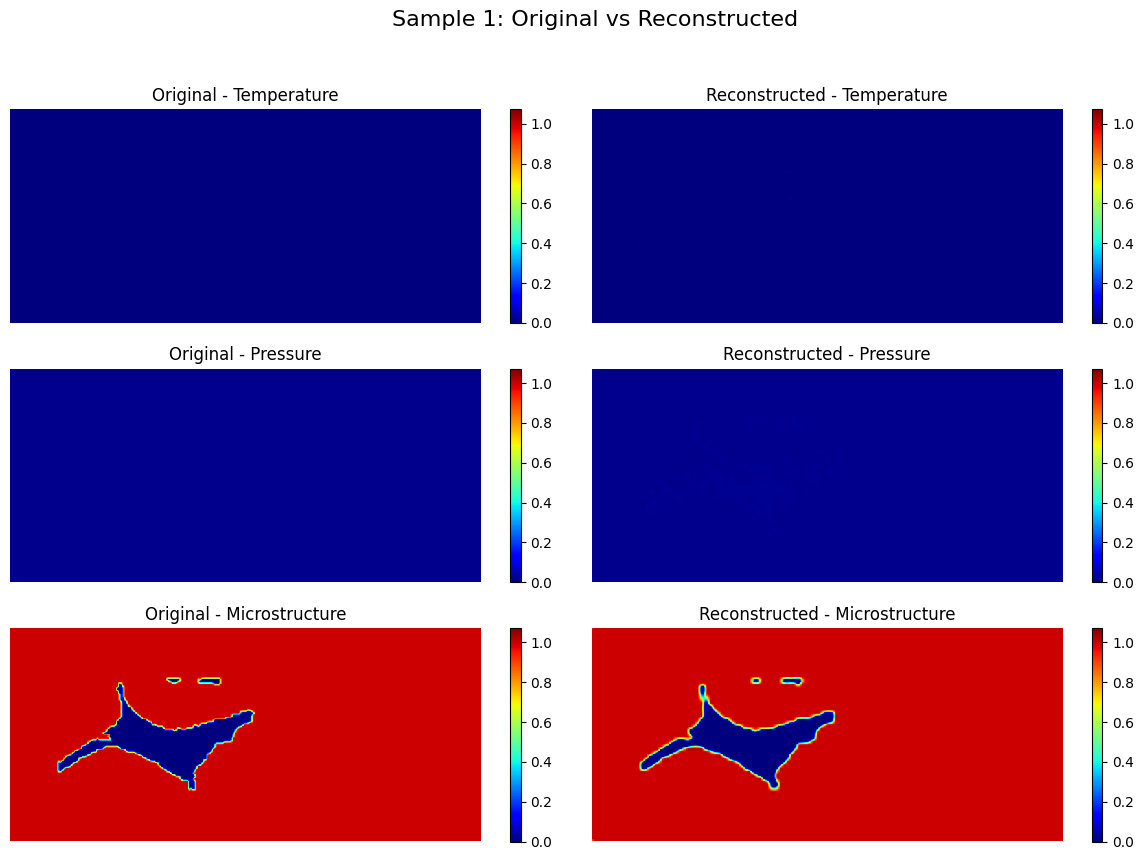

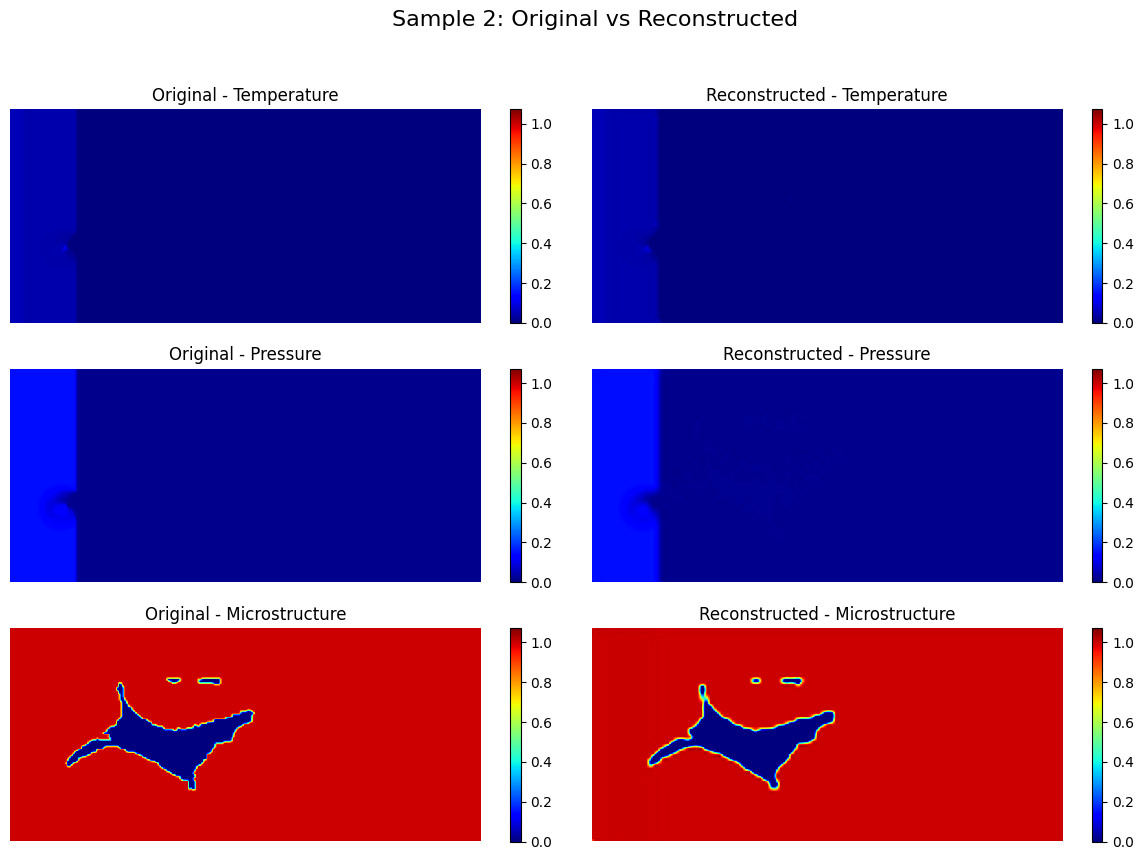

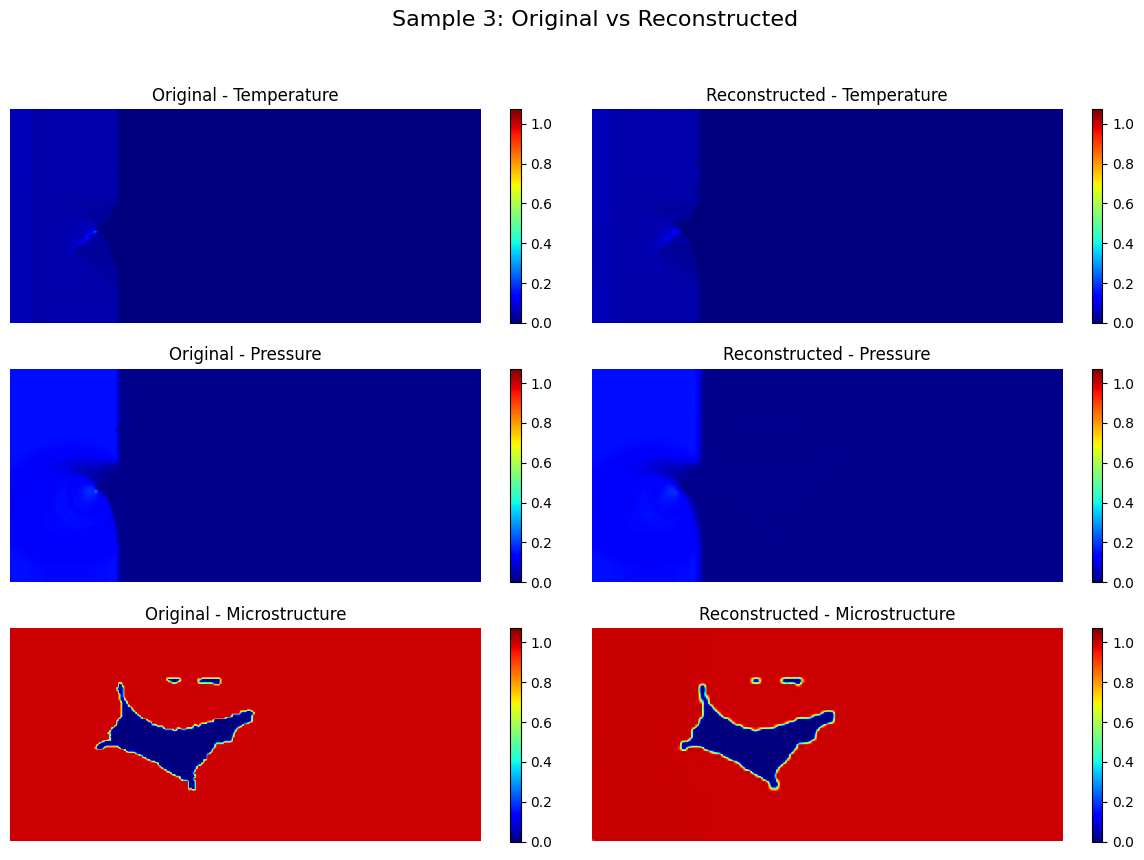

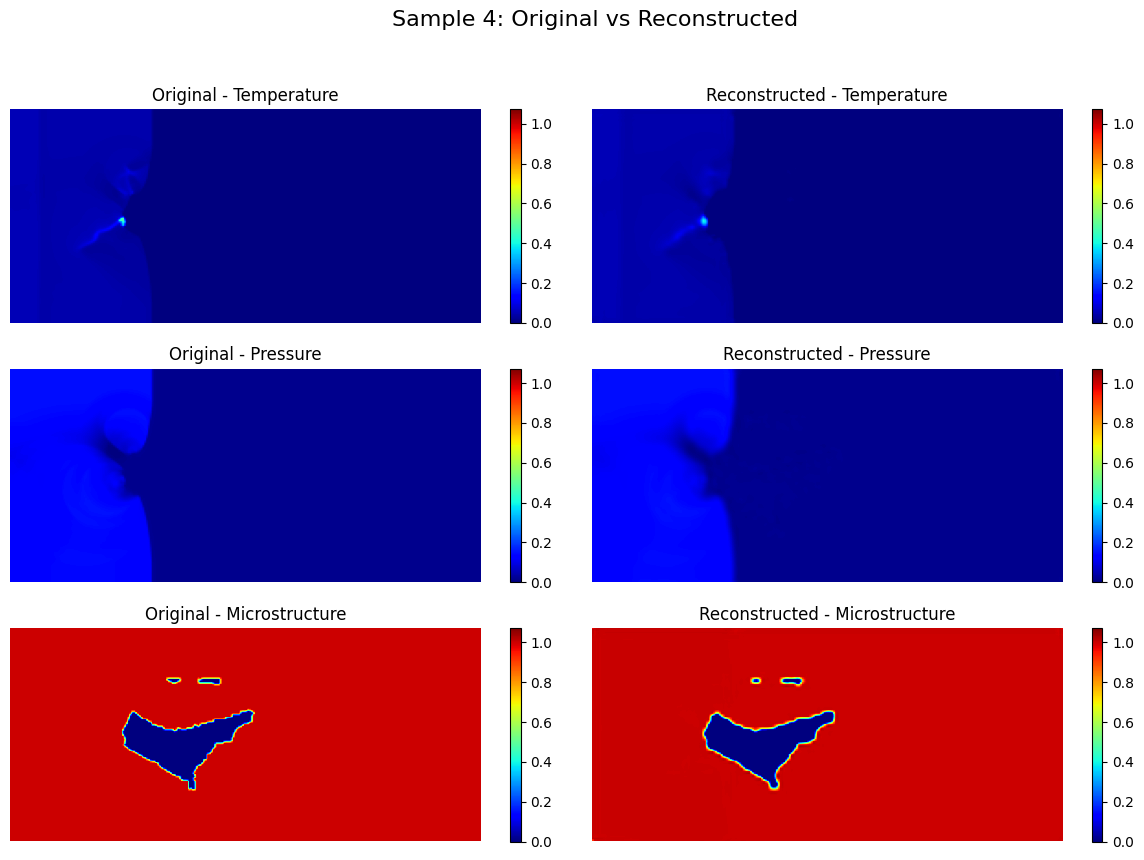

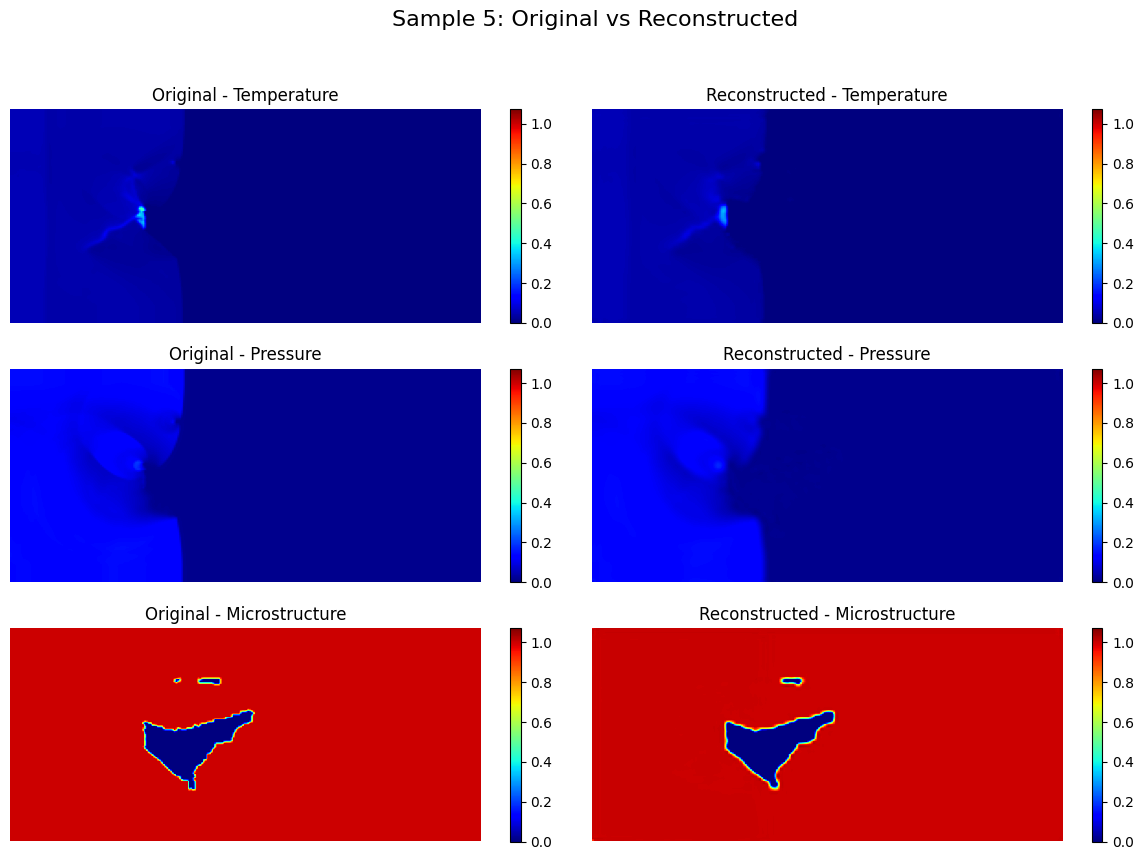

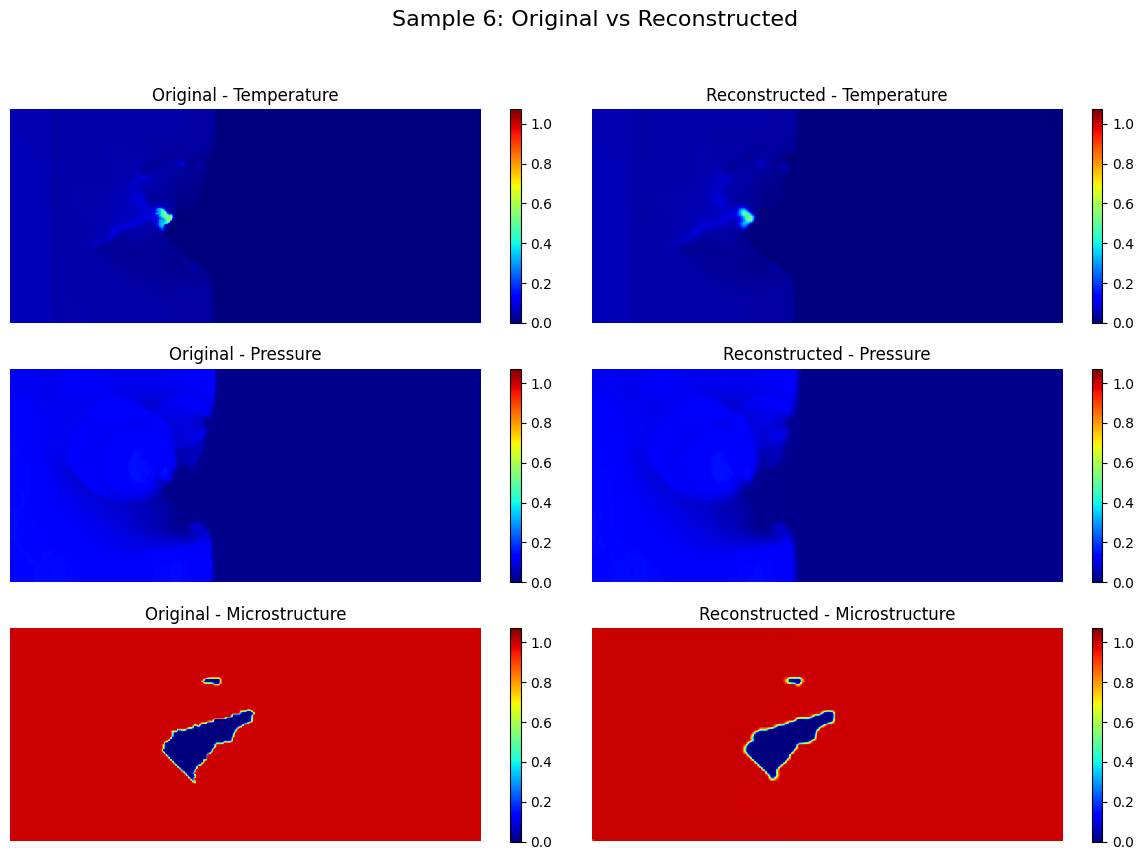

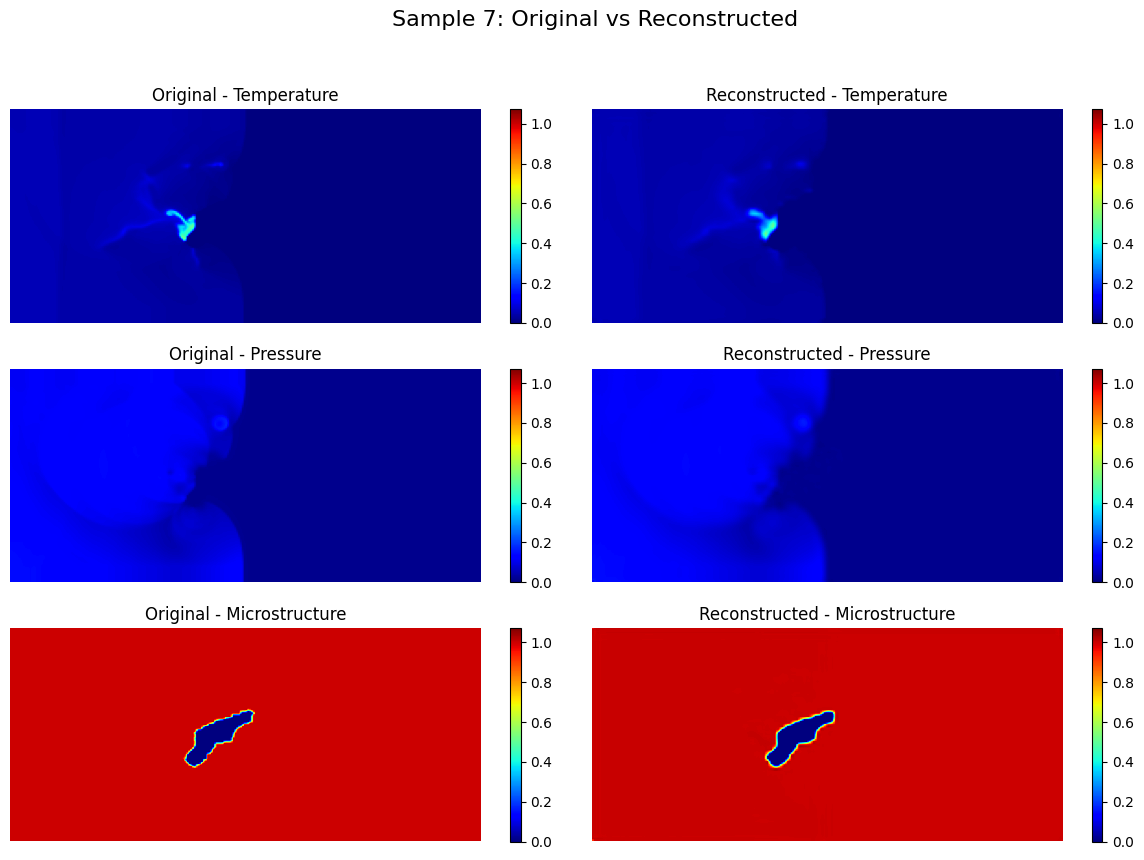

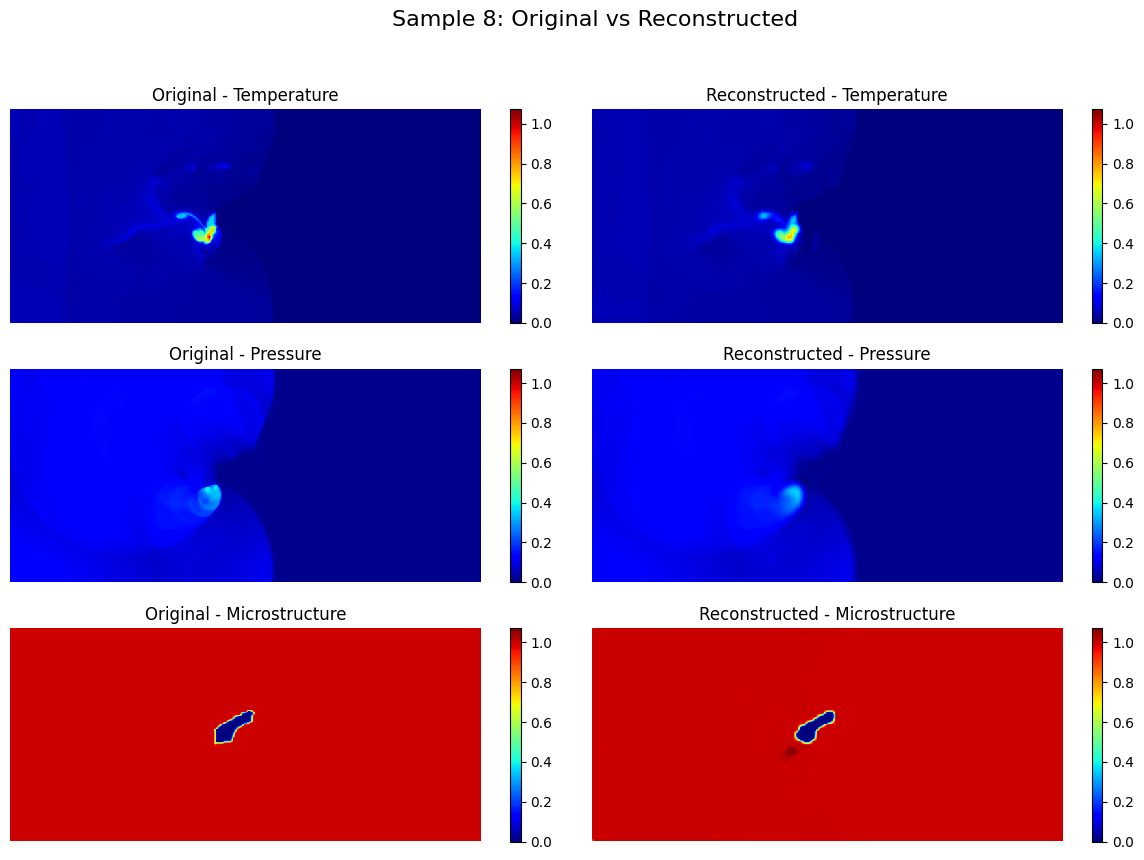

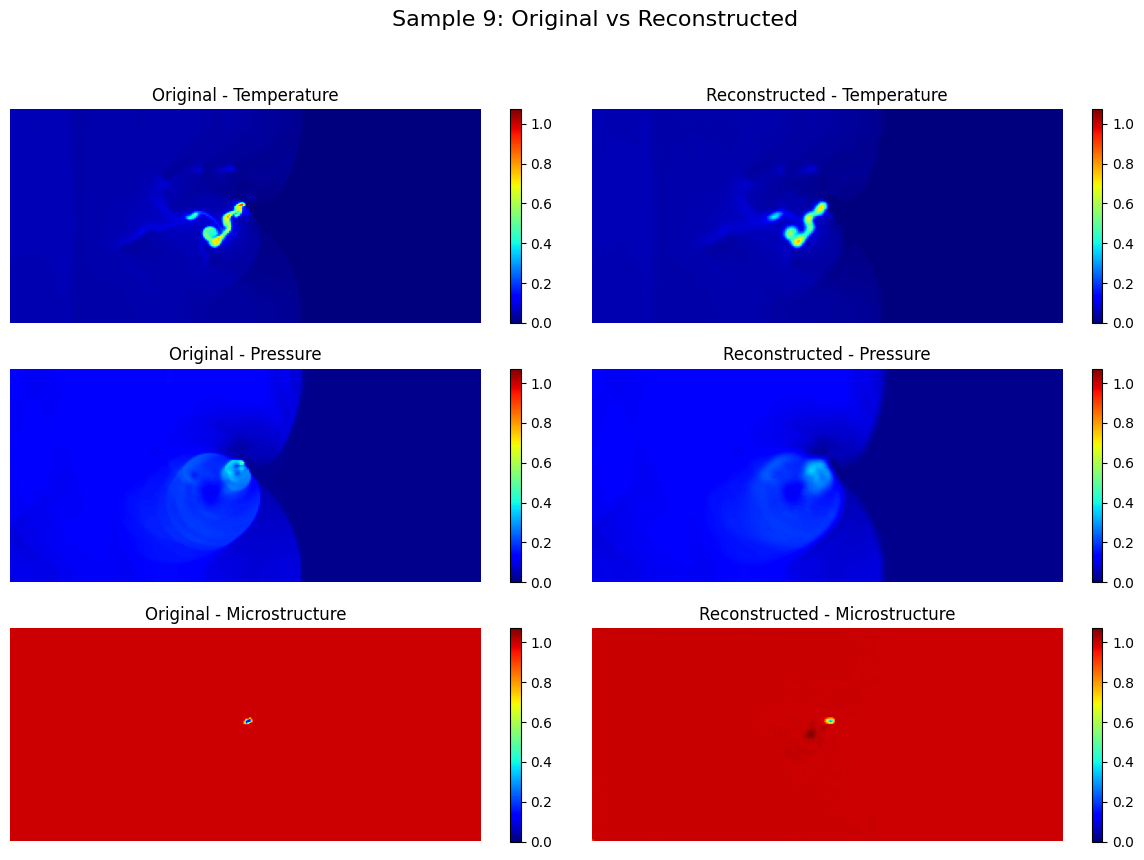

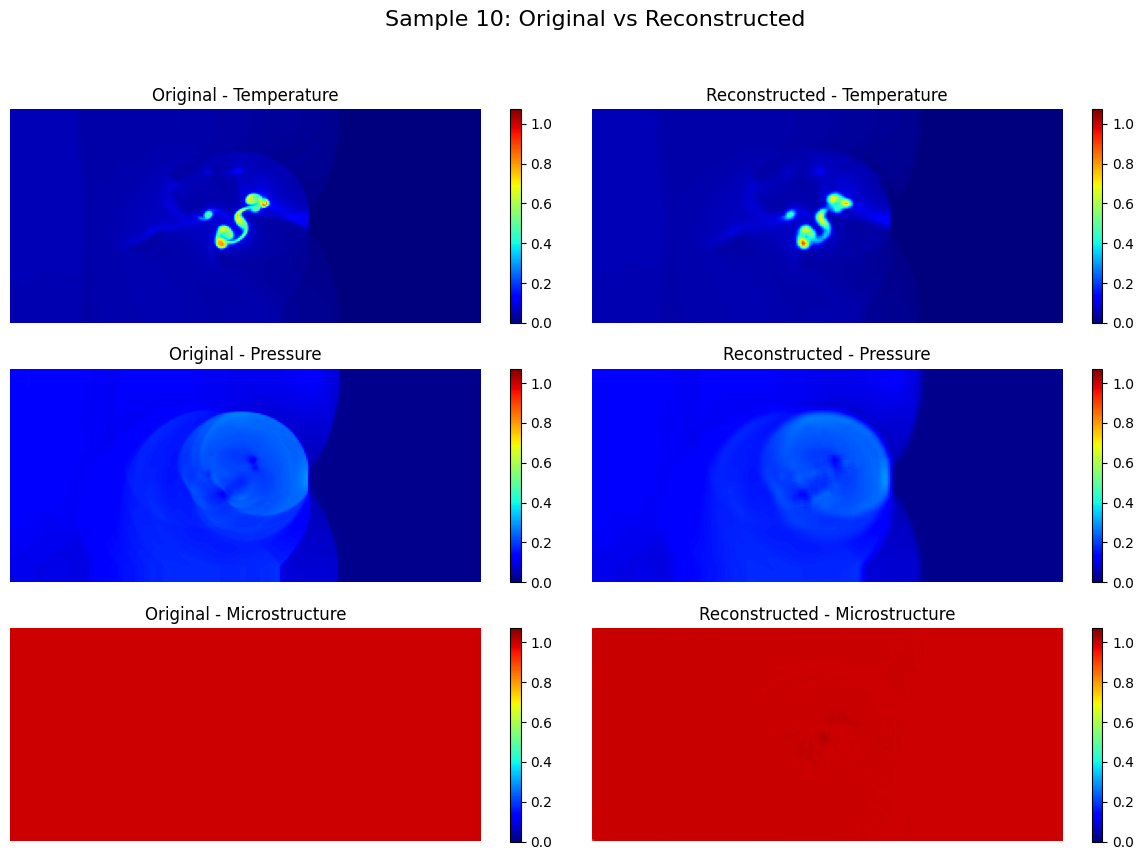

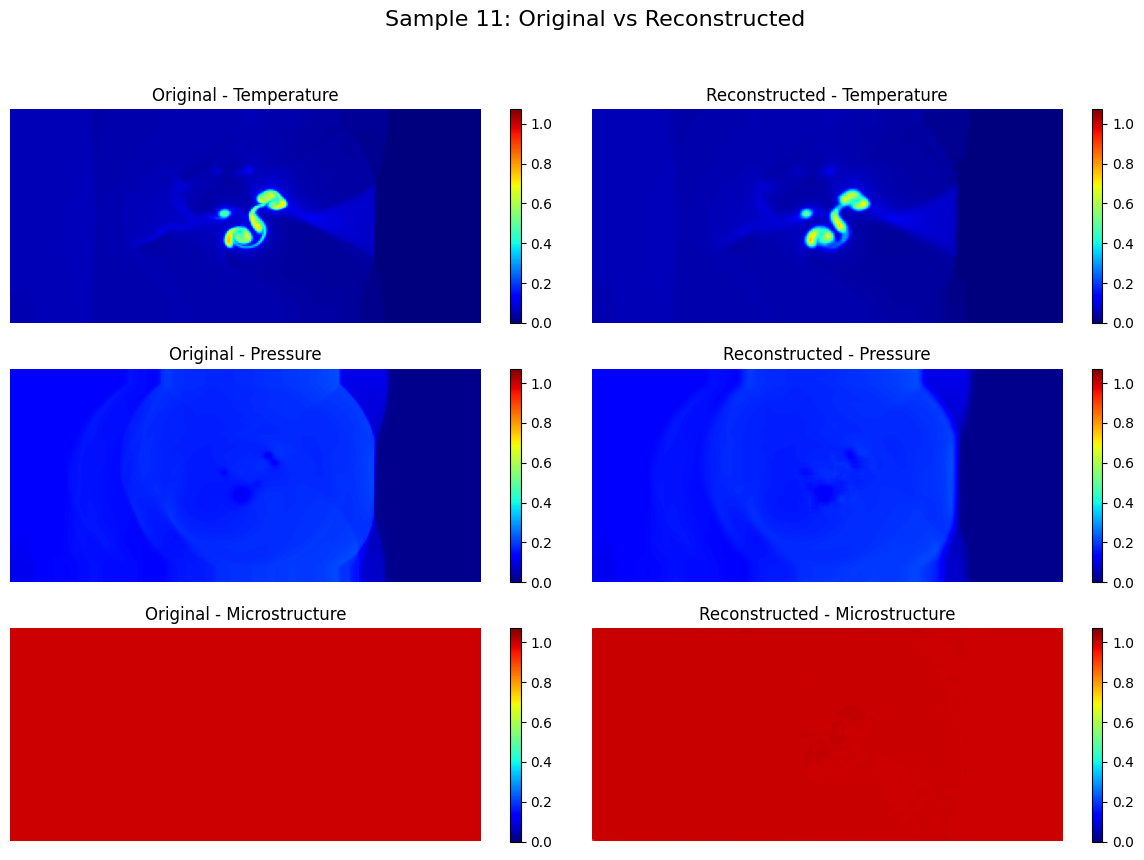

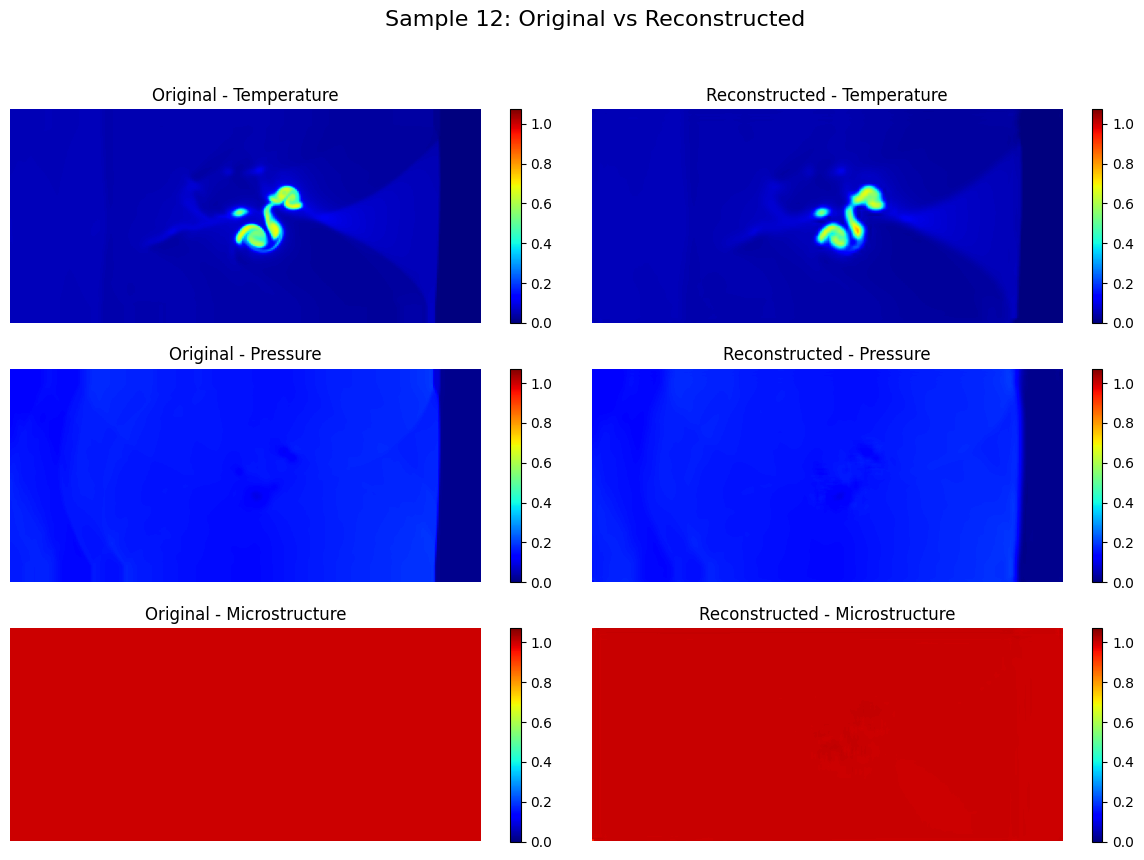

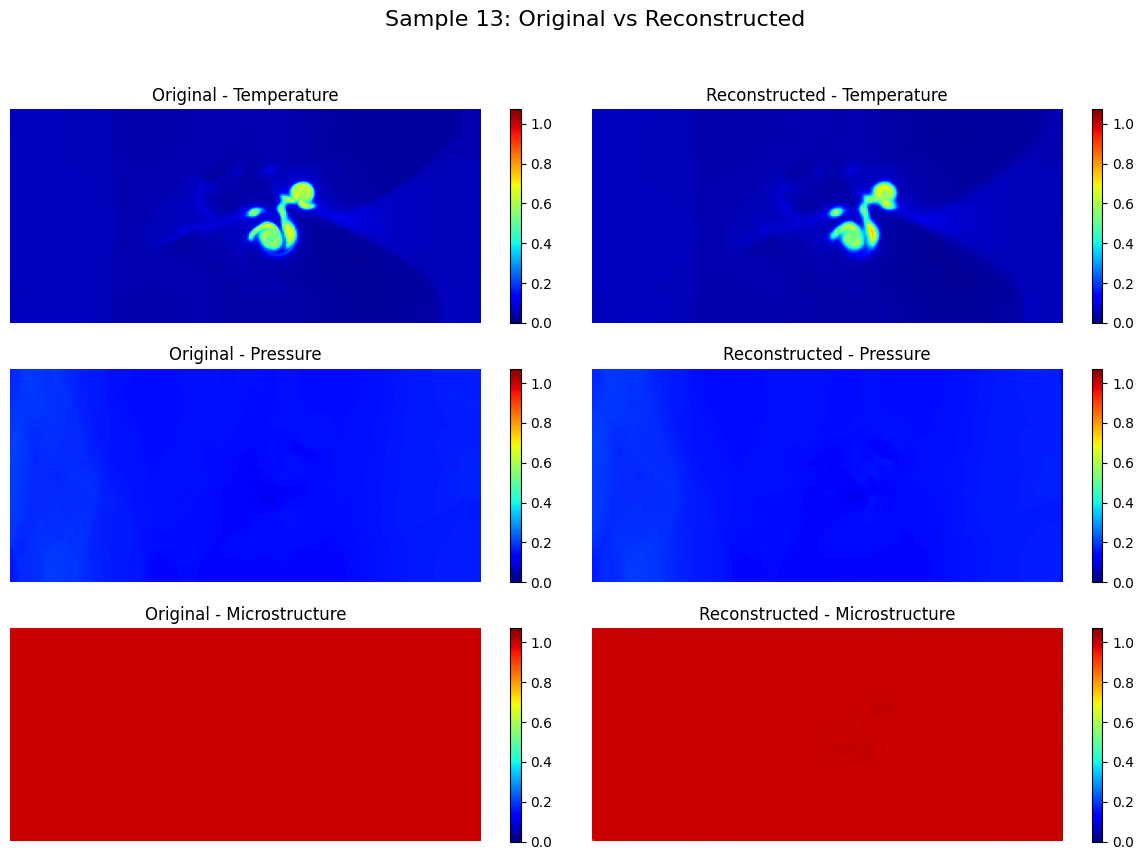

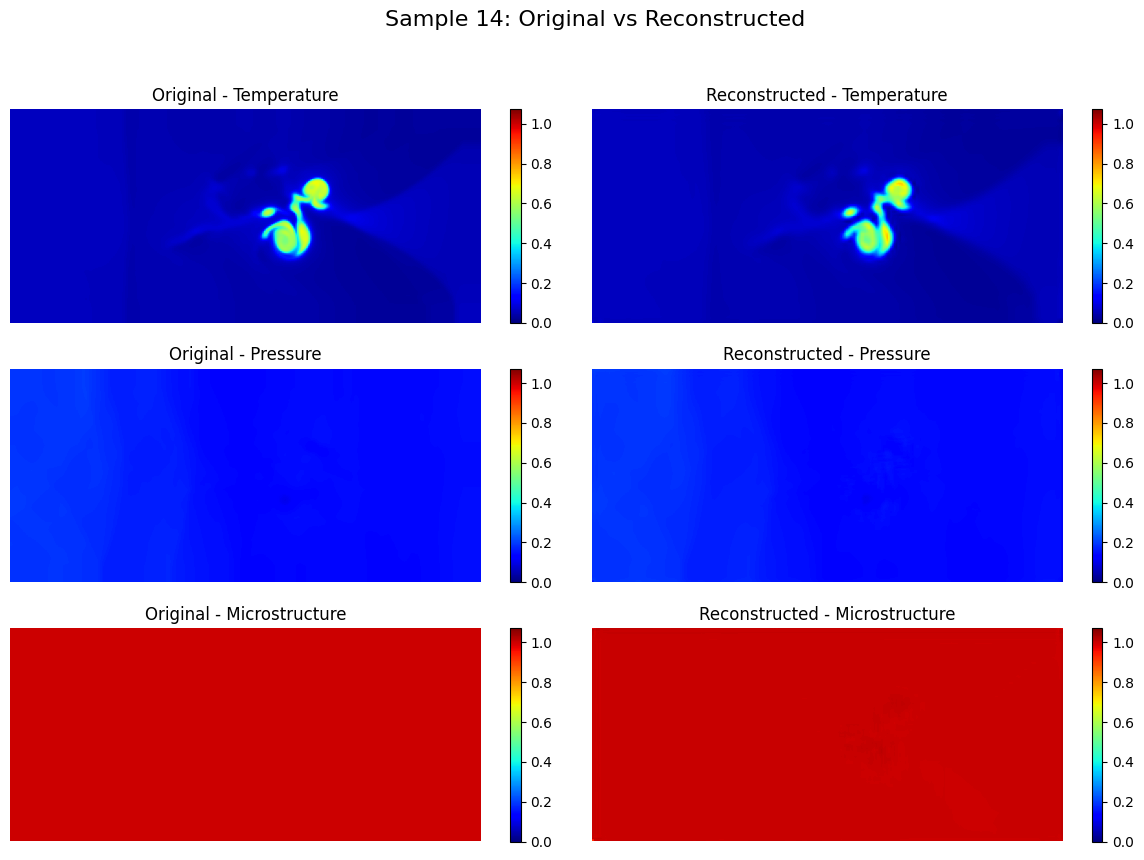

In [30]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (14ts each)
num_ts = n_ts-1  # Display up to 5 samples or fewer if dataset is smaller

visualize_reconstructions(
    X=X,
    reconstructions=just_AE_reconstruction_pred,
    channel_names=channel_names,
    num_ts=num_ts
)

### Z Hat Viz

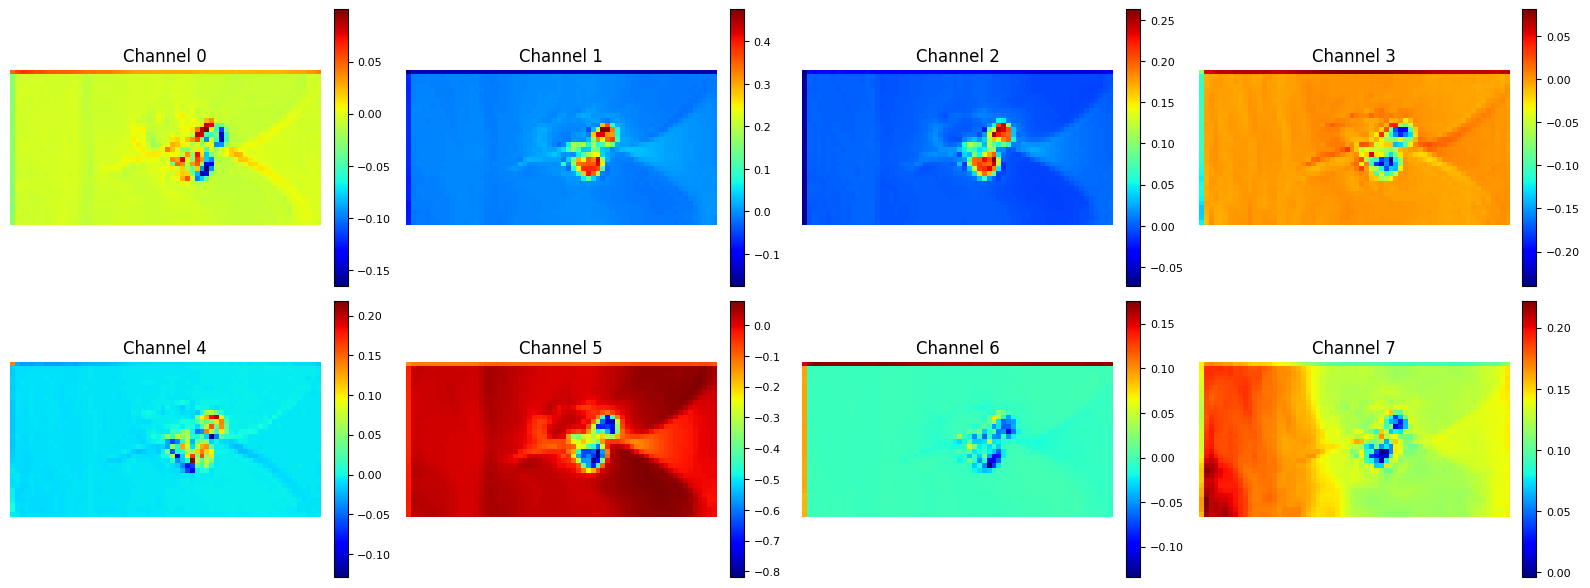

In [31]:
# select timestep to view
ts = 12
n_latent_channels = 8

plot_latent_channels_grid(
    tensor=single_ts_Zhat,
    timestep=ts,
    n_channels=n_latent_channels,
    grid_shape=(2, 4)
)

### Z_hat GIF

In [12]:
generate_latent_gif(
    tensor=single_ts_Zhat,
    file_save_name="TEST",
    n_latent_channels=8,
    grid_shape=(2, 4),
    duration=500,
    loop=0
)

Per-channel vmin and vmax computed.
GIF saved as 'TEST.gif'


### AE + Dynamics Evaluation (SNAPSHOT SINGLE TS)

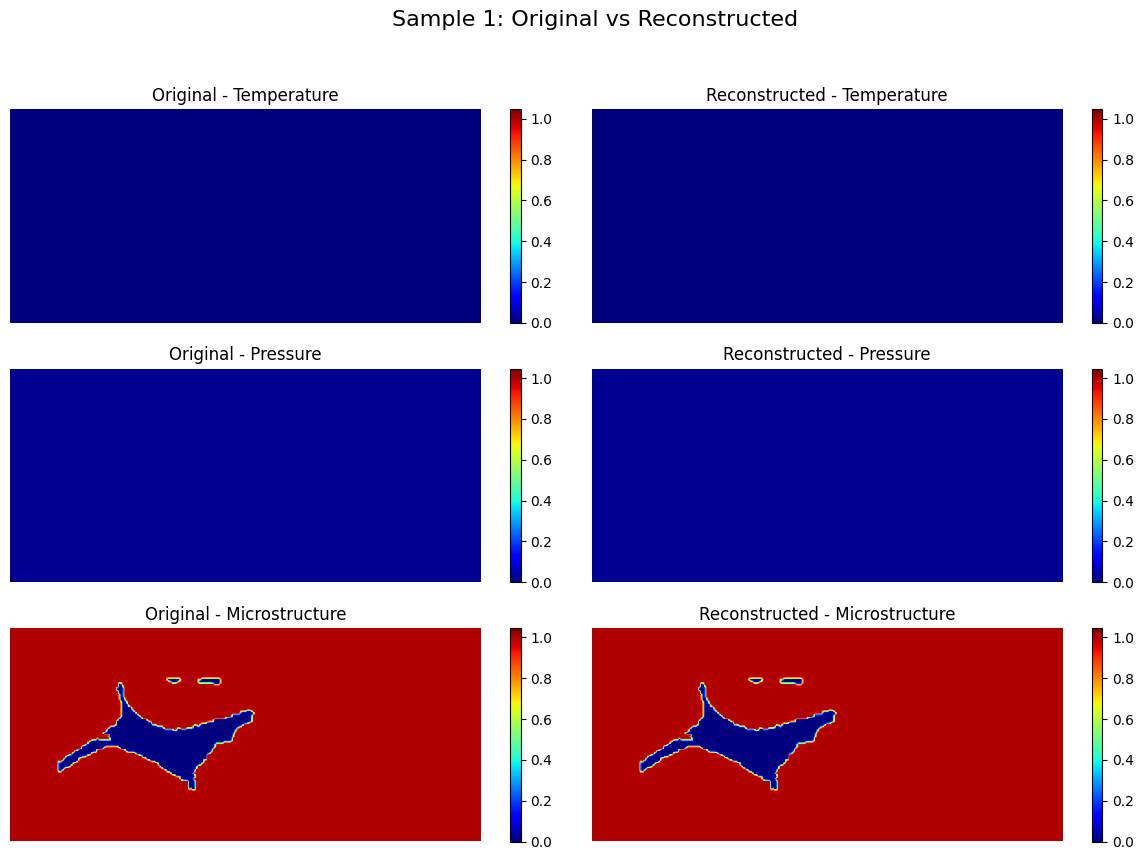

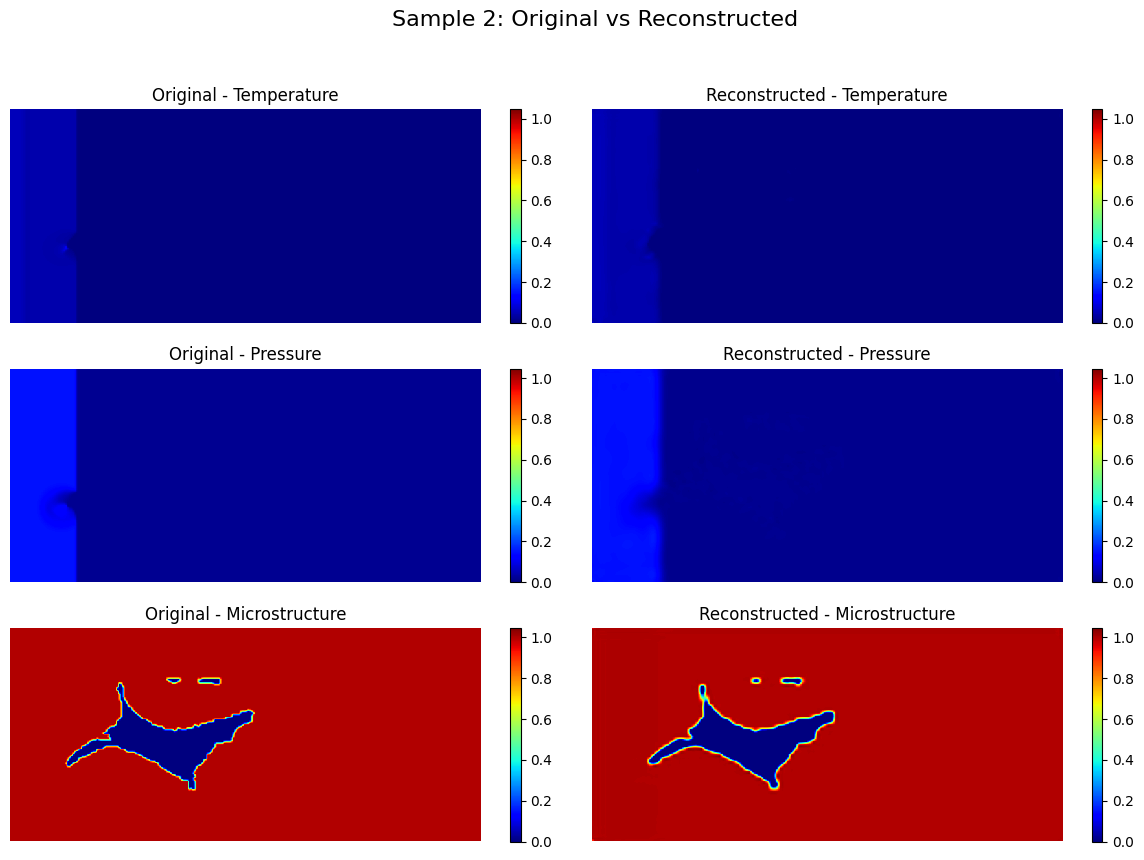

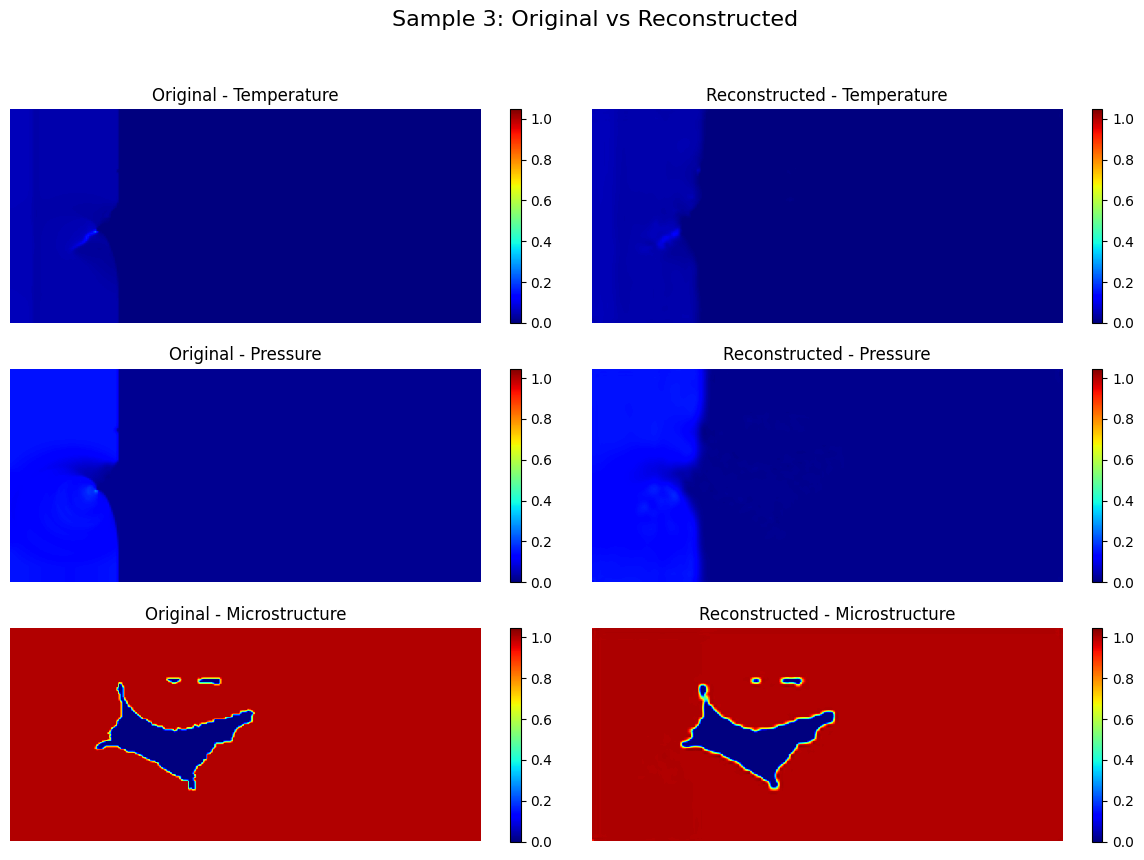

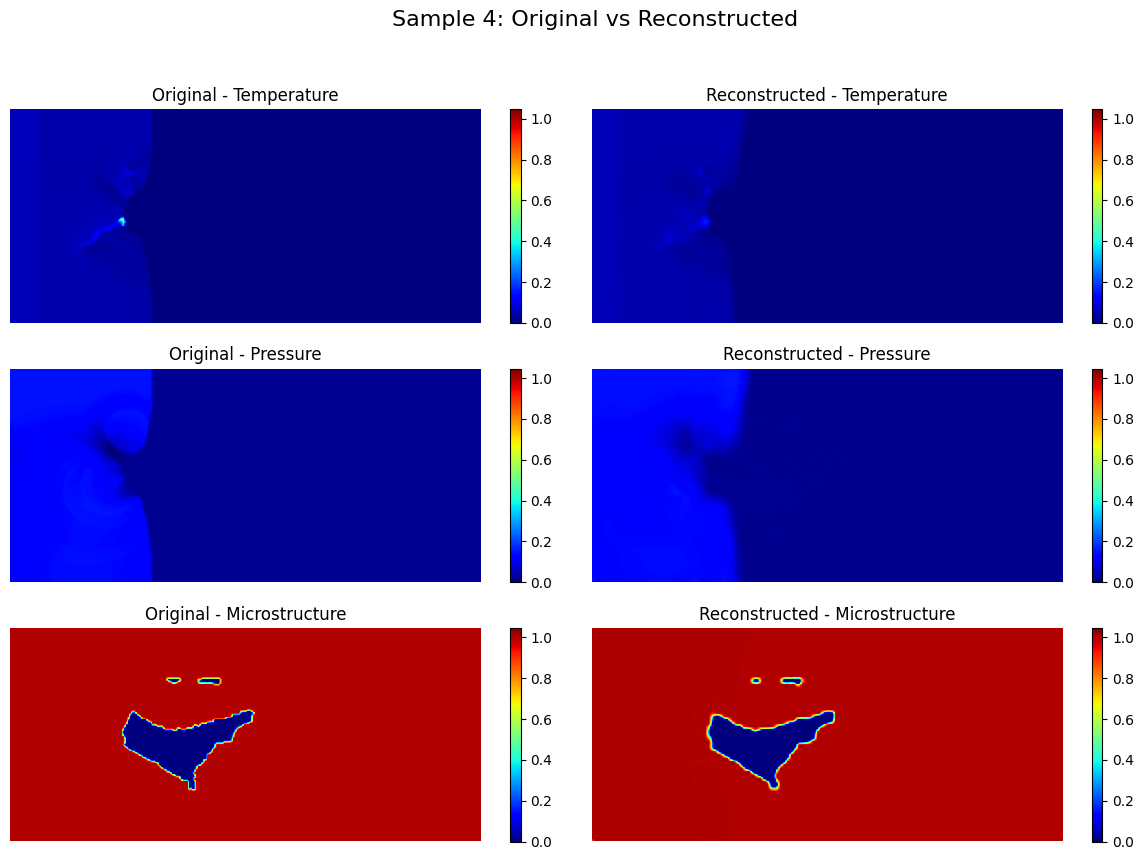

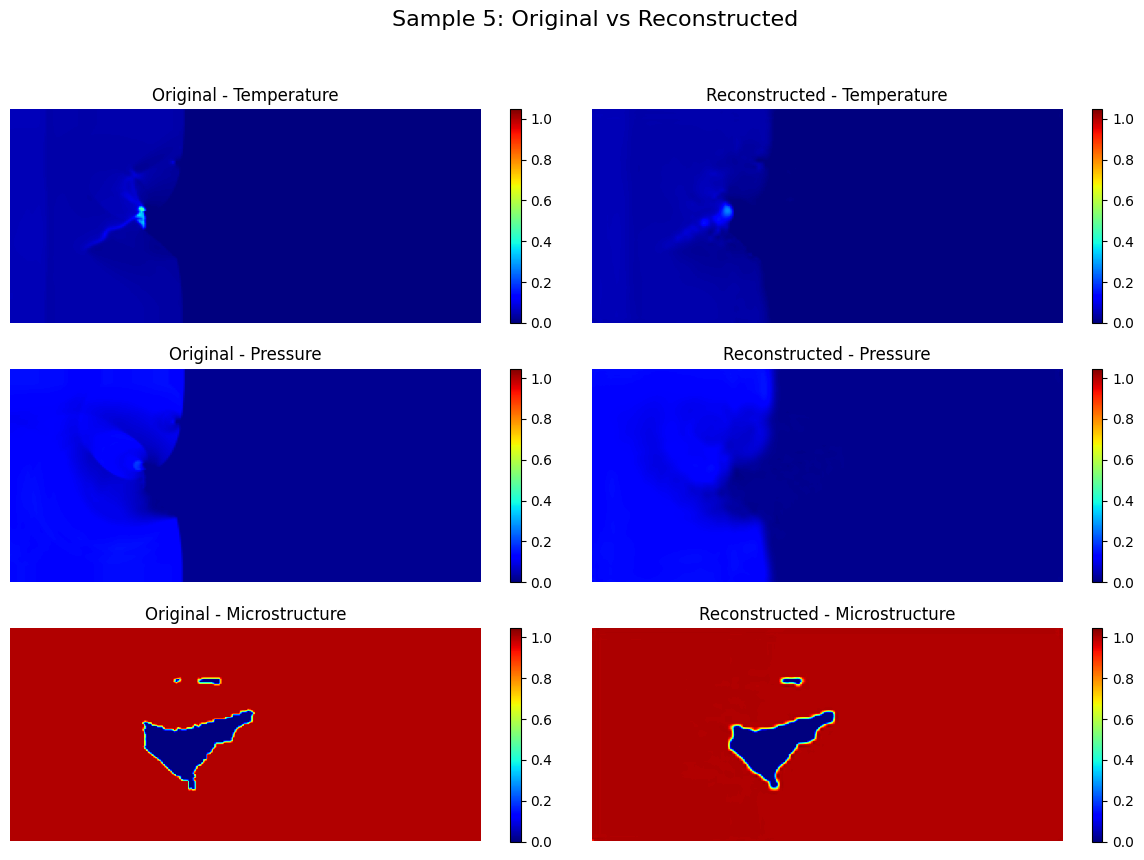

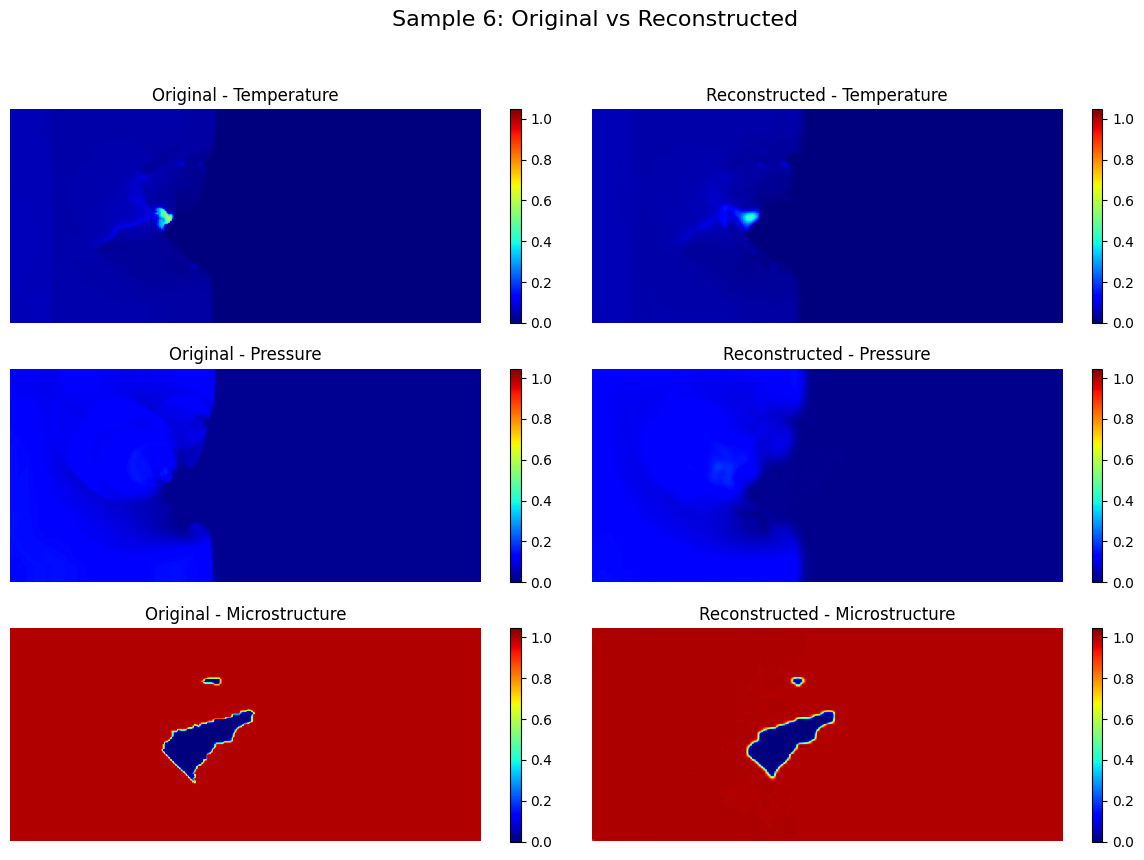

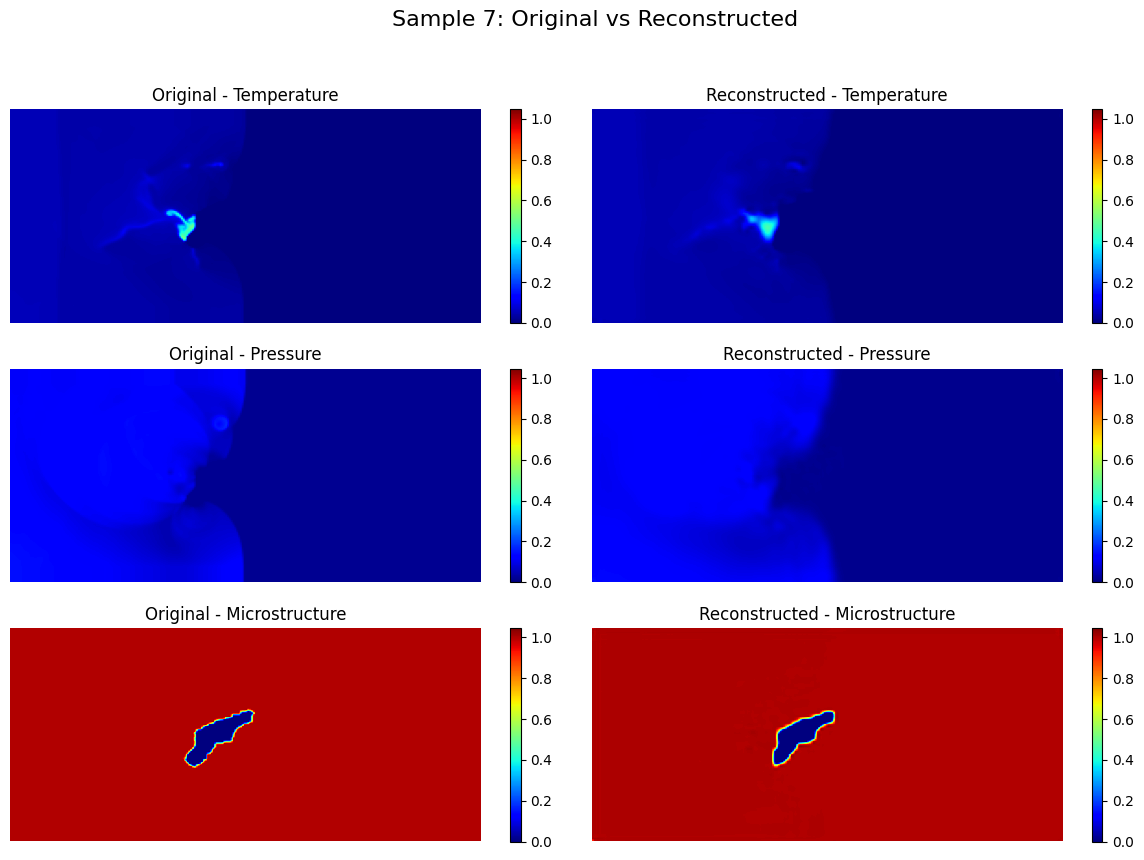

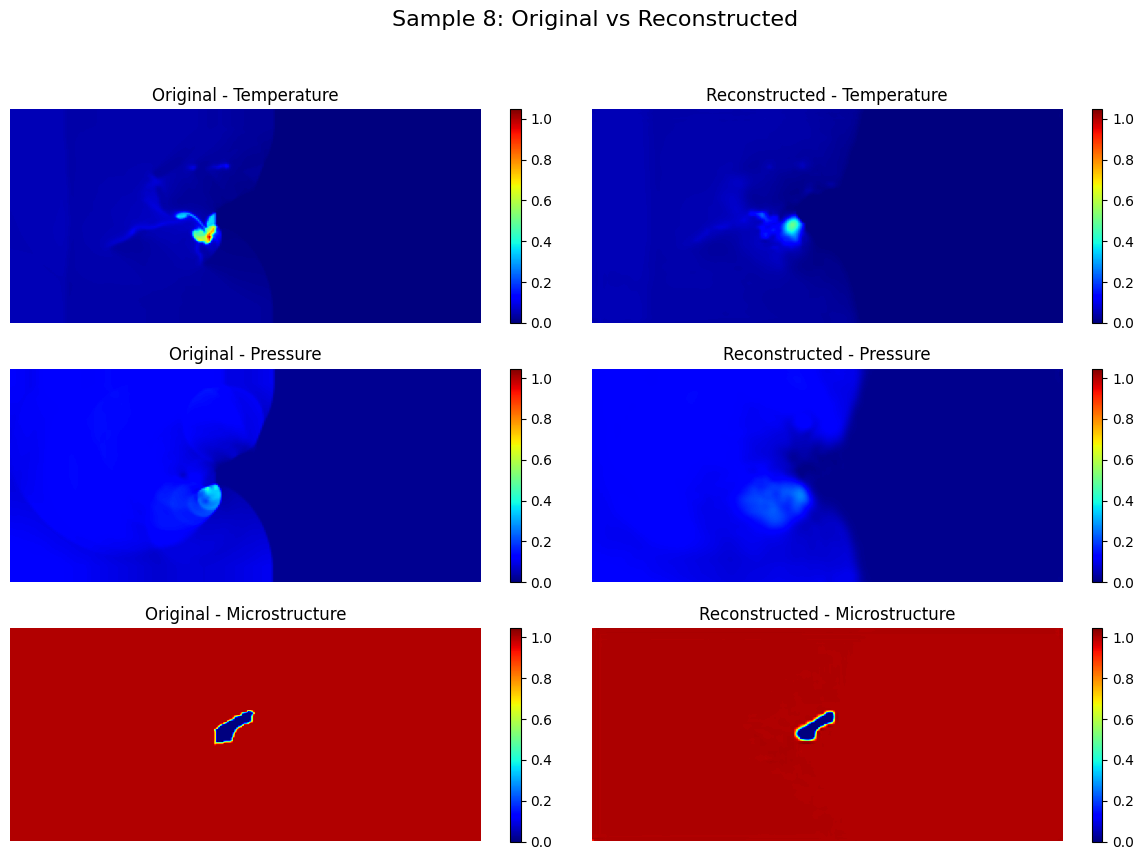

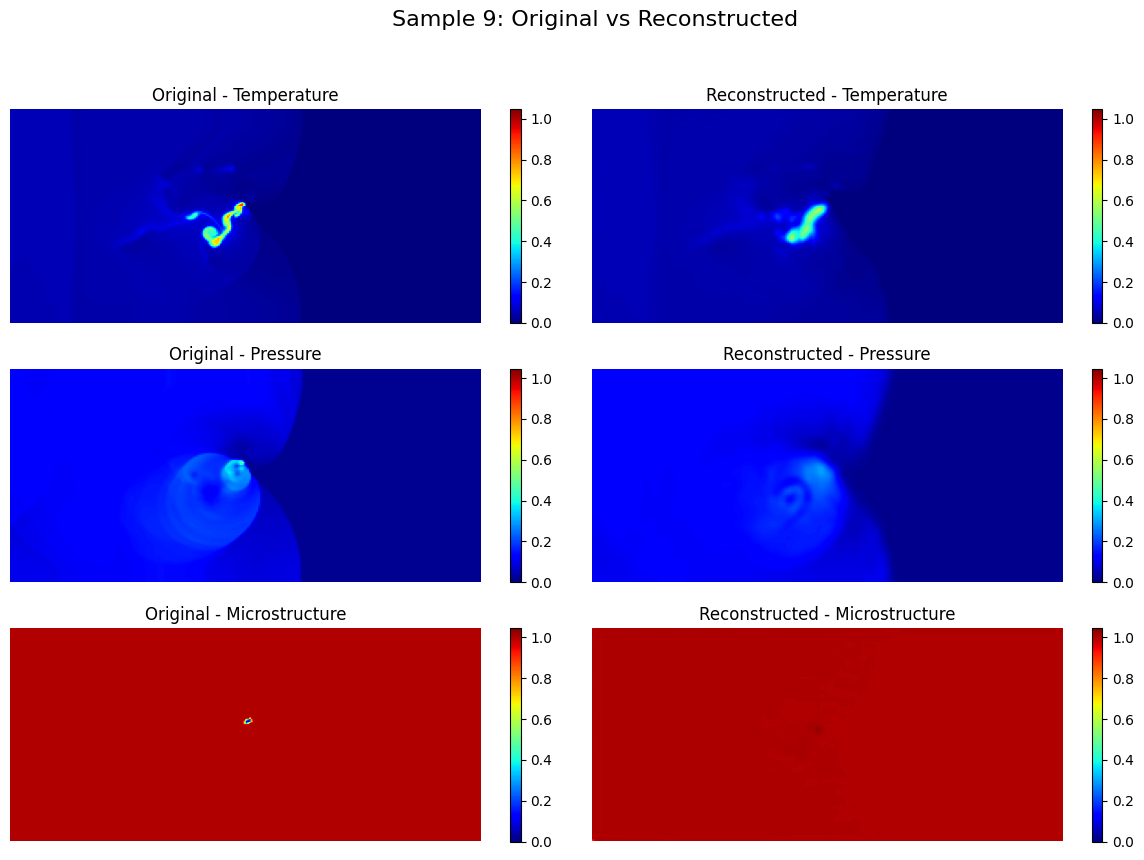

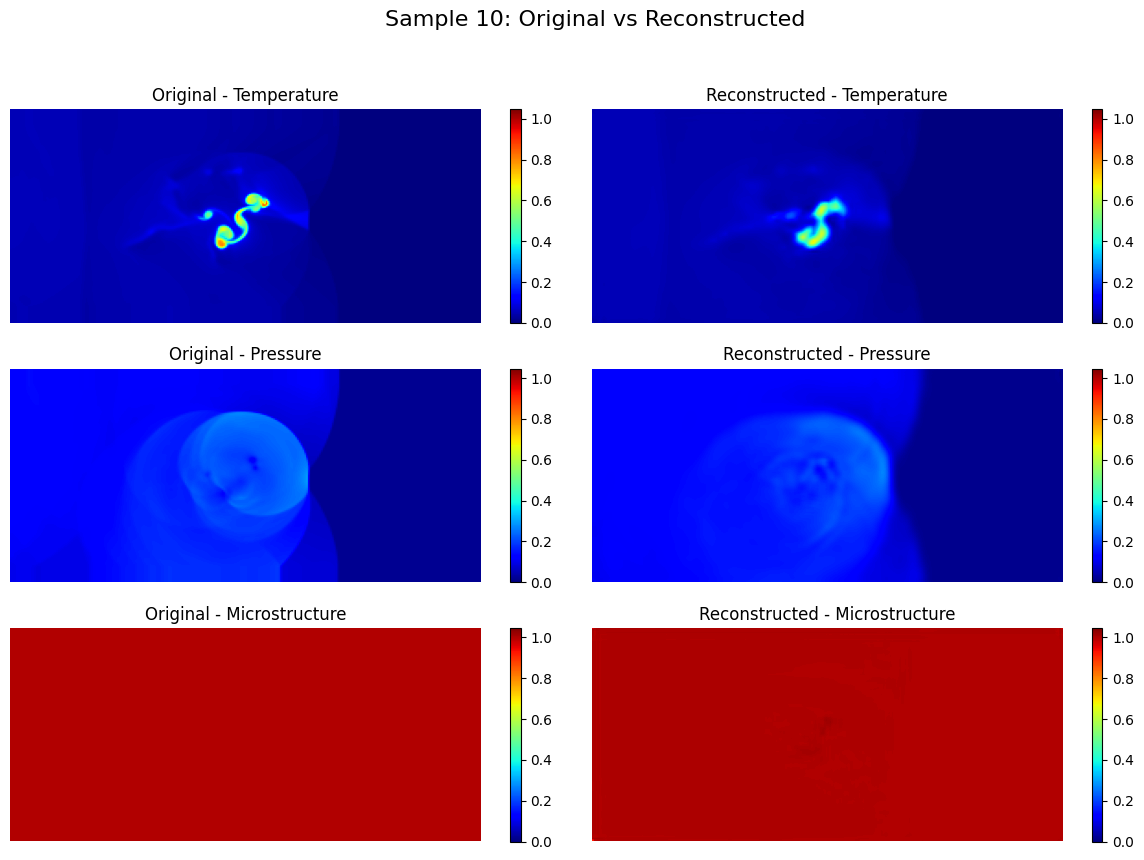

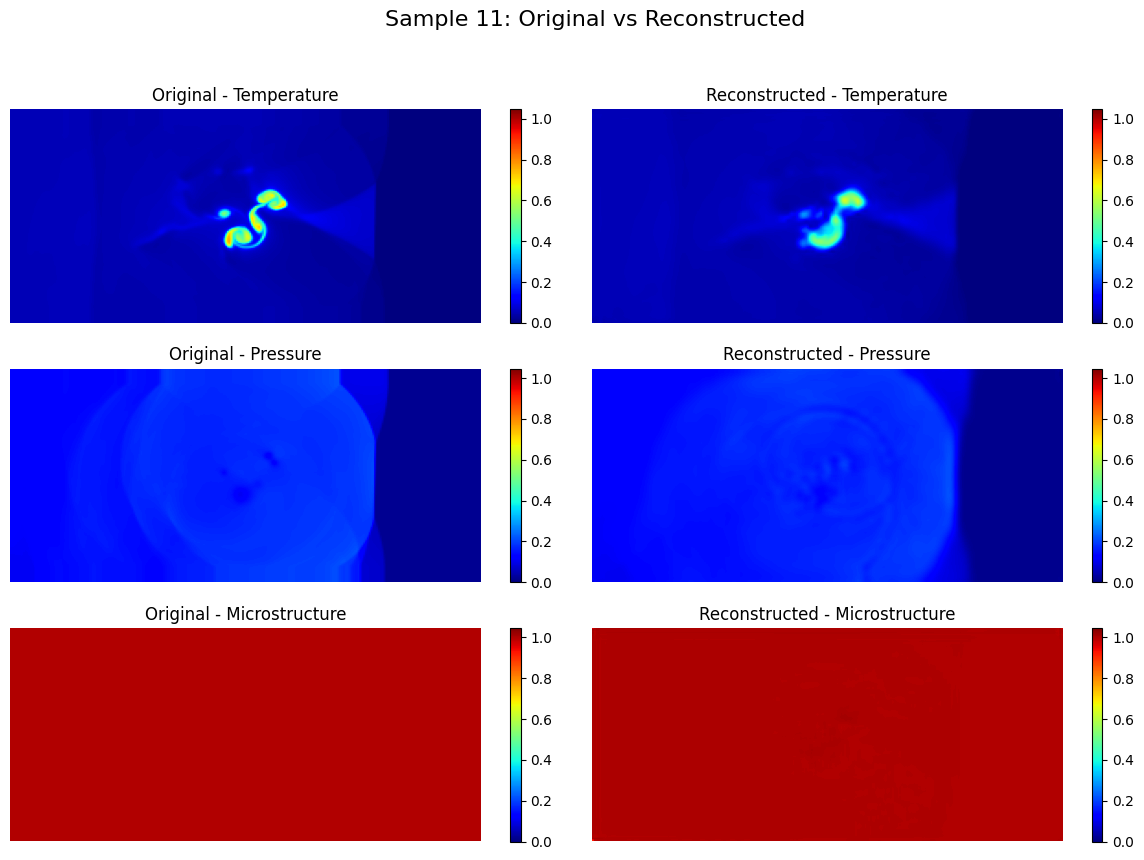

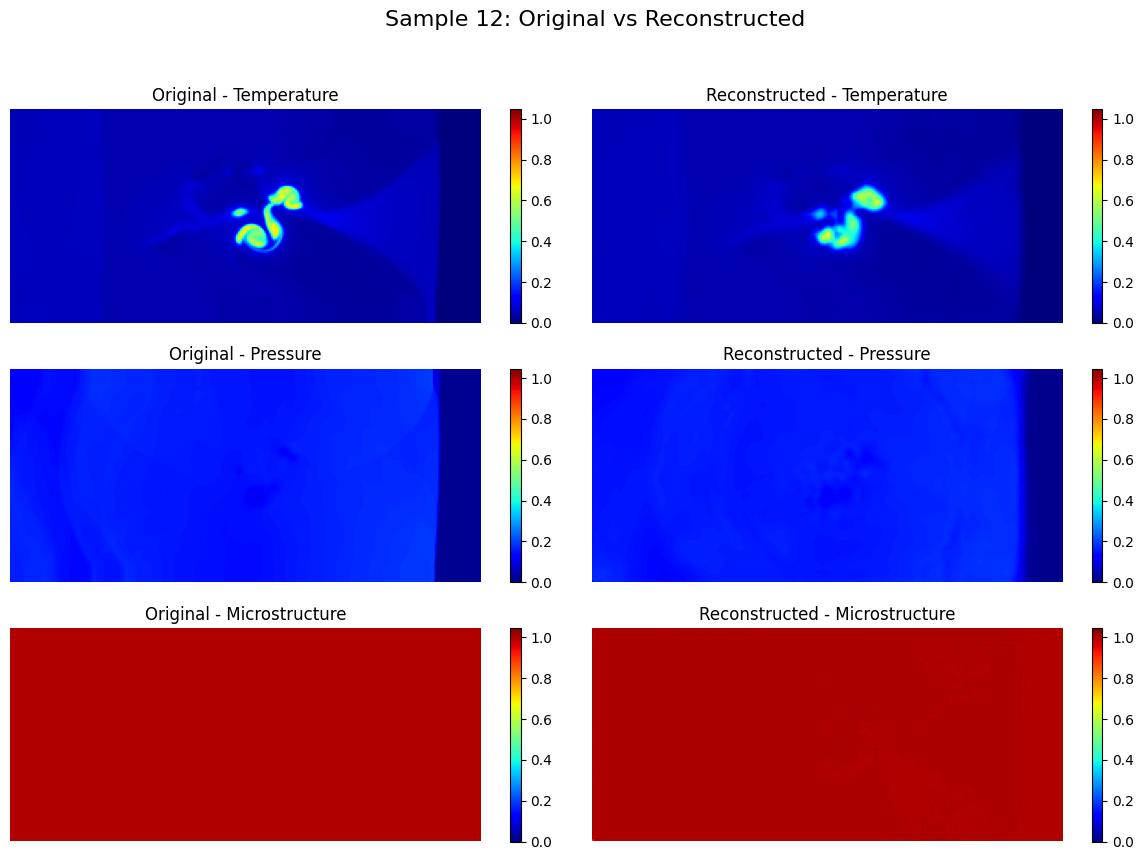

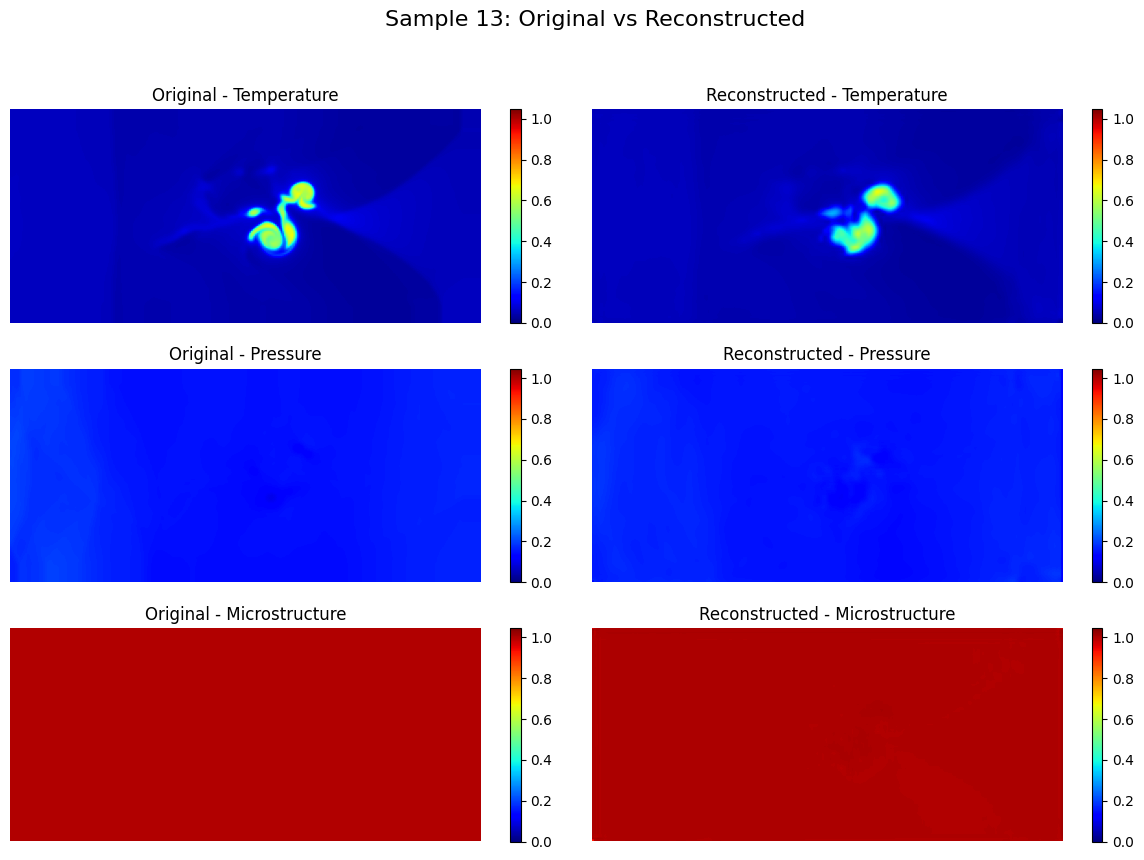

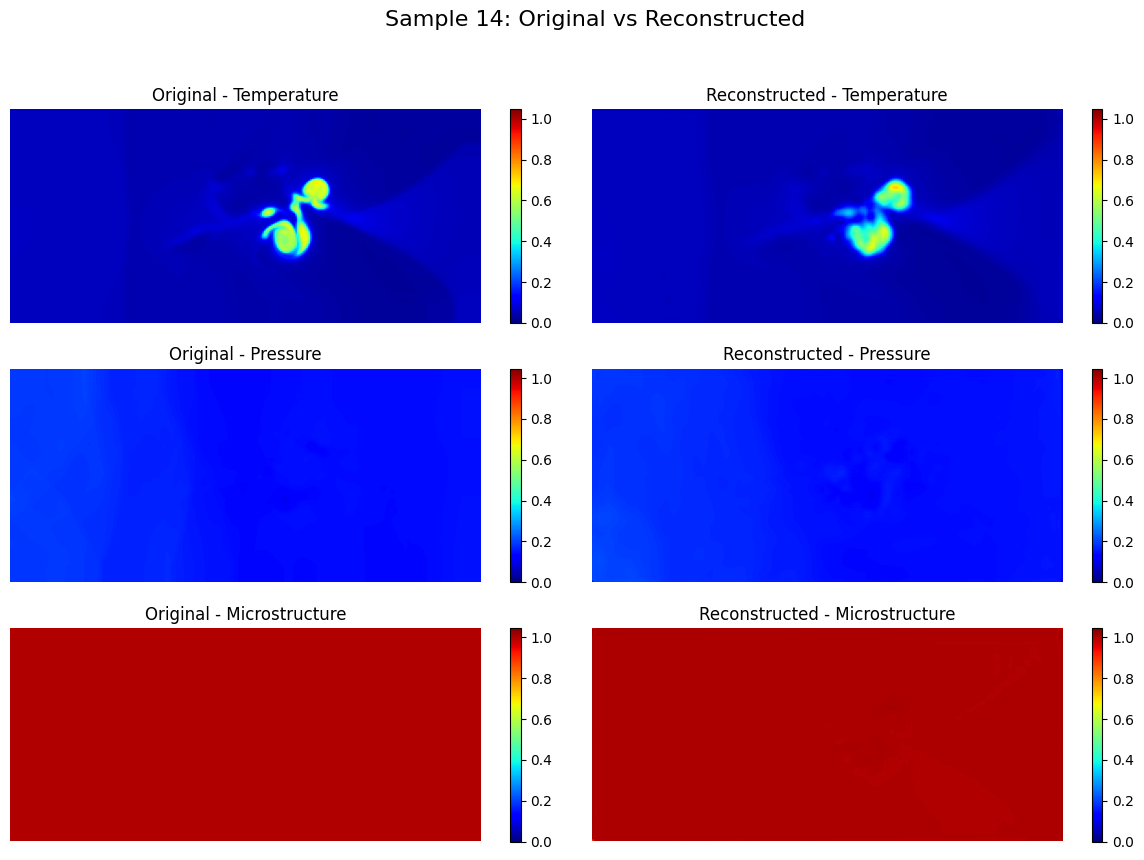

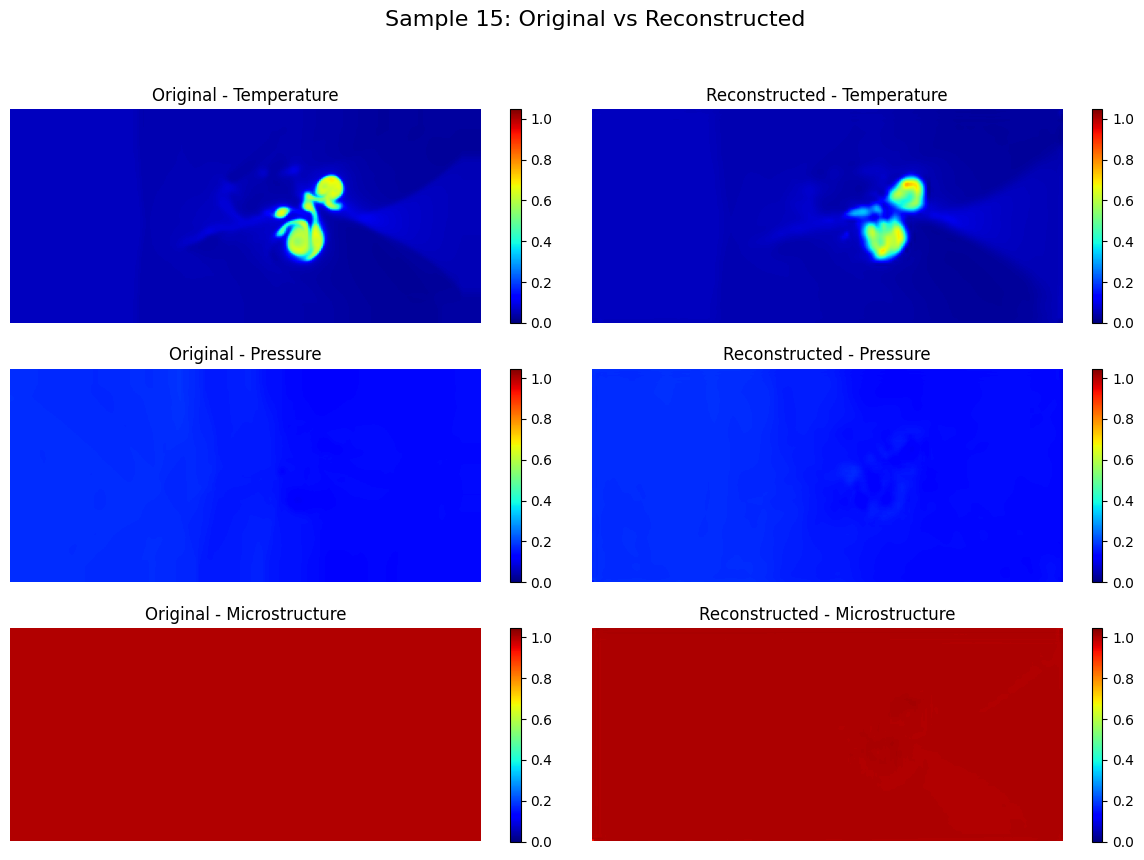

In [32]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_ts = n_ts

visualize_reconstructions(
    X=X,
    reconstructions=single_ts_full_reconstruction_pred,
    channel_names=channel_names,
    num_ts=num_ts
)

### GIF

In [33]:
generate_prediction_comparison_gif(
    X=X,
    prediction=single_ts_full_reconstruction_pred,
    channel_names=["Temperature", "Pressure", "Microstructure"],
    file_name="TEST",
    plot_title="Single TS Prediction"
)

/tmp/ipykernel_74966/3807836999.py:141: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to TEST.gif


# Latent Rollout Preds

In [30]:
n_channels = 3
n_ts = 15

GT = []
pred_latent = []
pred = []

with torch.no_grad():
    z, decoded = model_init(ic.unsqueeze(0).to(device), n_ts=n_ts, mode='pred')

z = z.squeeze(1).cpu()  # squeeze is remenant of needing to stack for rollout training
decoded = decoded.squeeze(1).cpu()

In [29]:
# import time
# import torch
# import numpy as np  # for standard deviation

# n_channels = 3
# n_ts = 15

# GT = []
# pred_latent = []
# pred = []

# # Warm-up runs
# for _ in range(10):
#     with torch.no_grad():
#         _ = model_init(ic.unsqueeze(0).to(device), n_ts=n_ts, mode='pred')
# torch.cuda.synchronize()

# # Timing runs
# timings = []
# for _ in range(100):
#     torch.cuda.synchronize()
#     start_time = time.time()

#     with torch.no_grad():
#         z, decoded = model_init(ic.unsqueeze(0).to(device), n_ts=n_ts, mode='pred')

#     torch.cuda.synchronize()
#     end_time = time.time()
#     timings.append(end_time - start_time)

# timings = np.array(timings)

# print(f"Inference time over 100 runs:")
# print(f"  Avg:  {timings.mean():.6f} s")
# print(f"  Std:  {timings.std():.6f} s")
# print(f"  Min:  {timings.min():.6f} s")
# print(f"  Max:  {timings.max():.6f} s")


Inference time over 100 runs:
  Avg:  0.045446 s
  Std:  0.006021 s
  Min:  0.043269 s
  Max:  0.090583 s


In [15]:
z.shape, decoded.shape

(torch.Size([15, 1, 8, 32, 64]), torch.Size([15, 1, 3, 128, 256]))

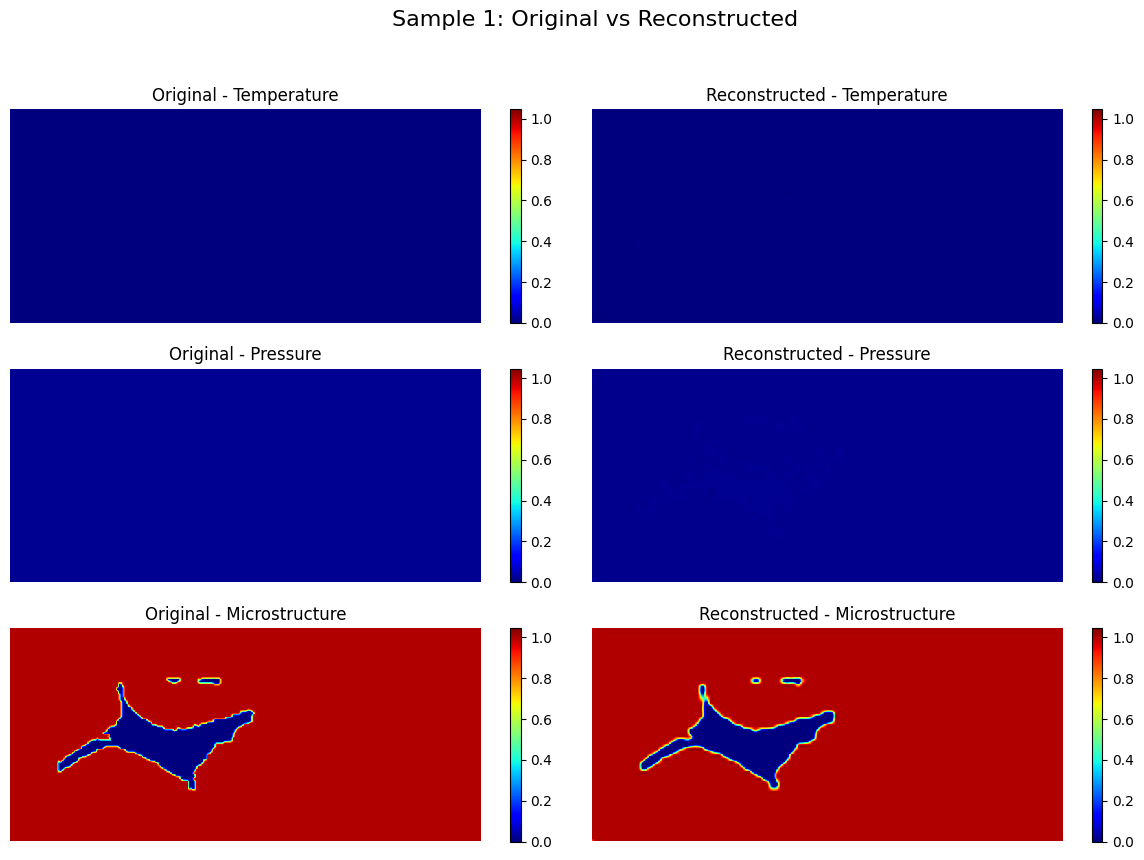

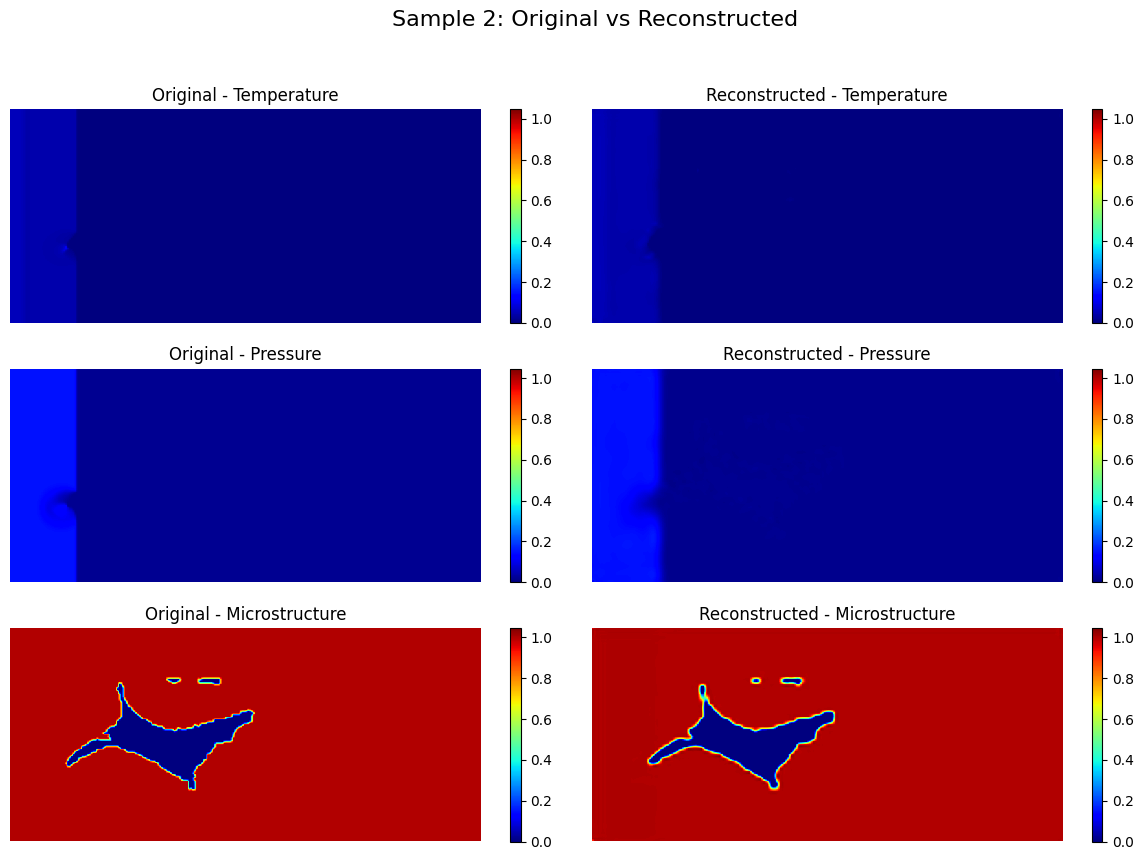

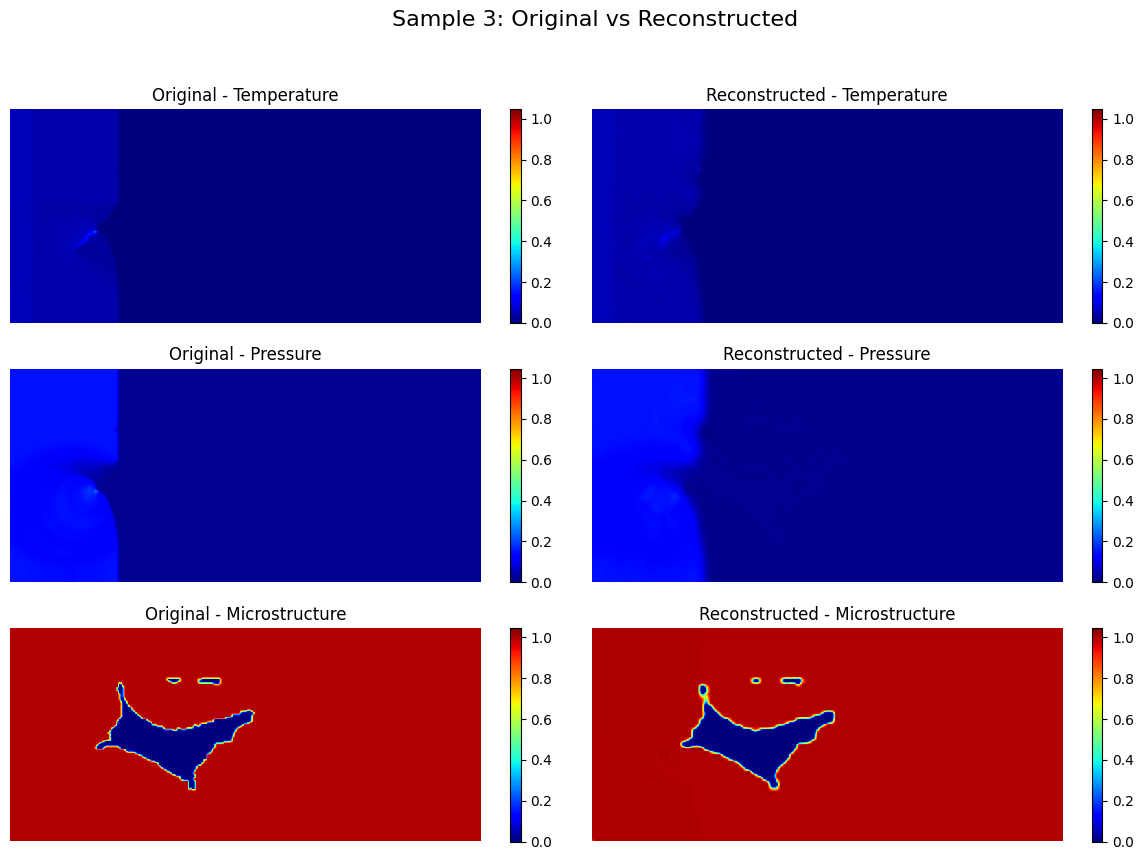

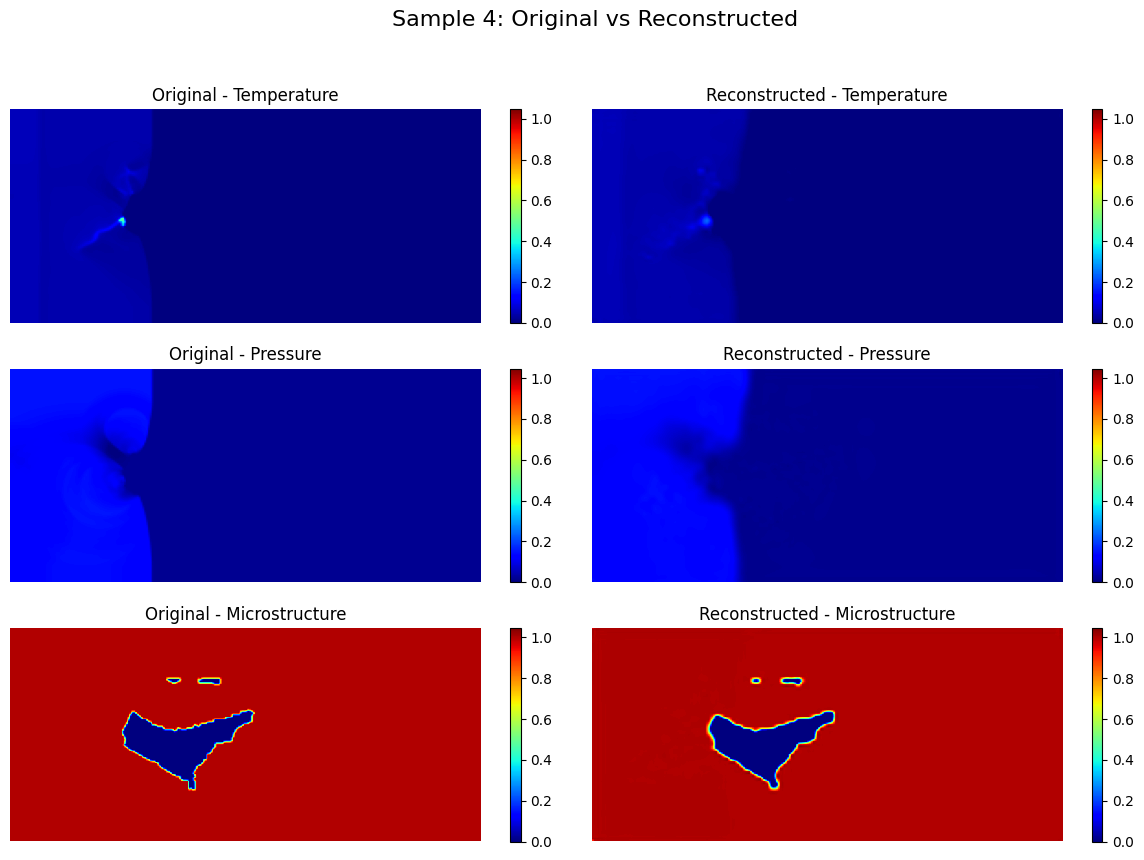

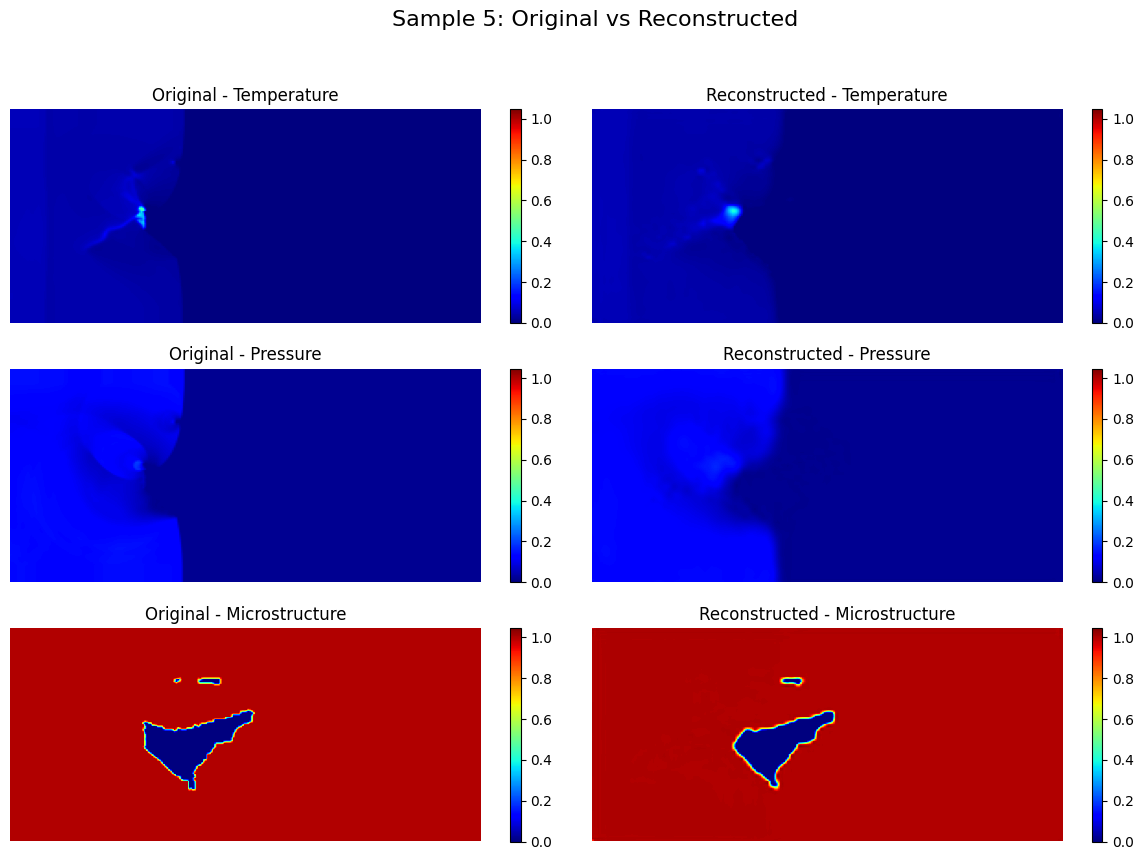

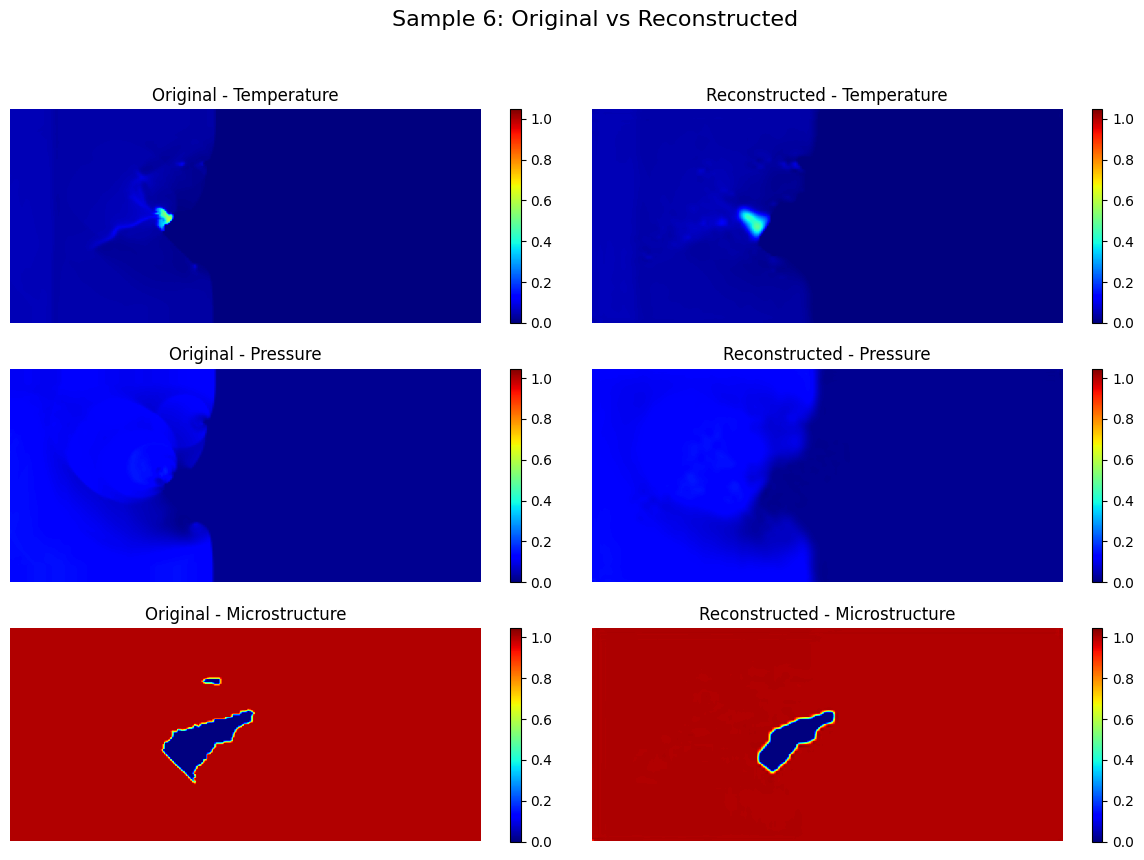

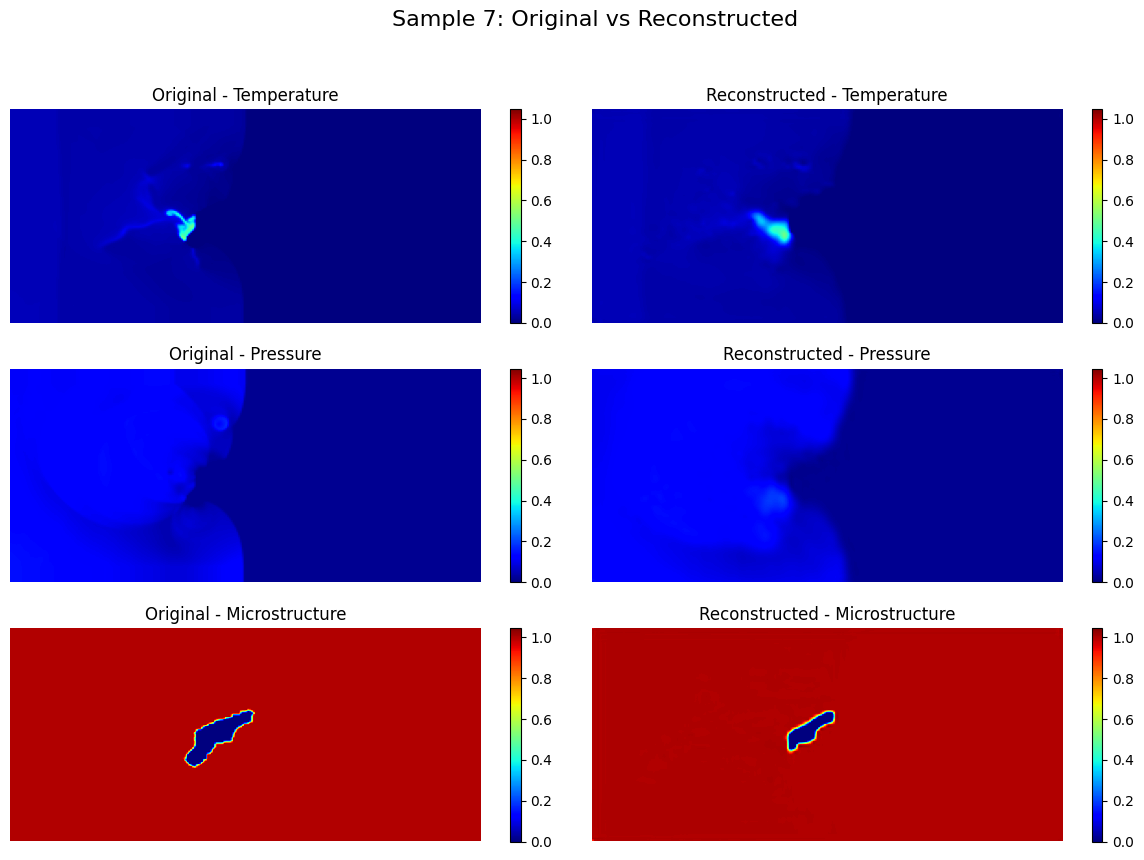

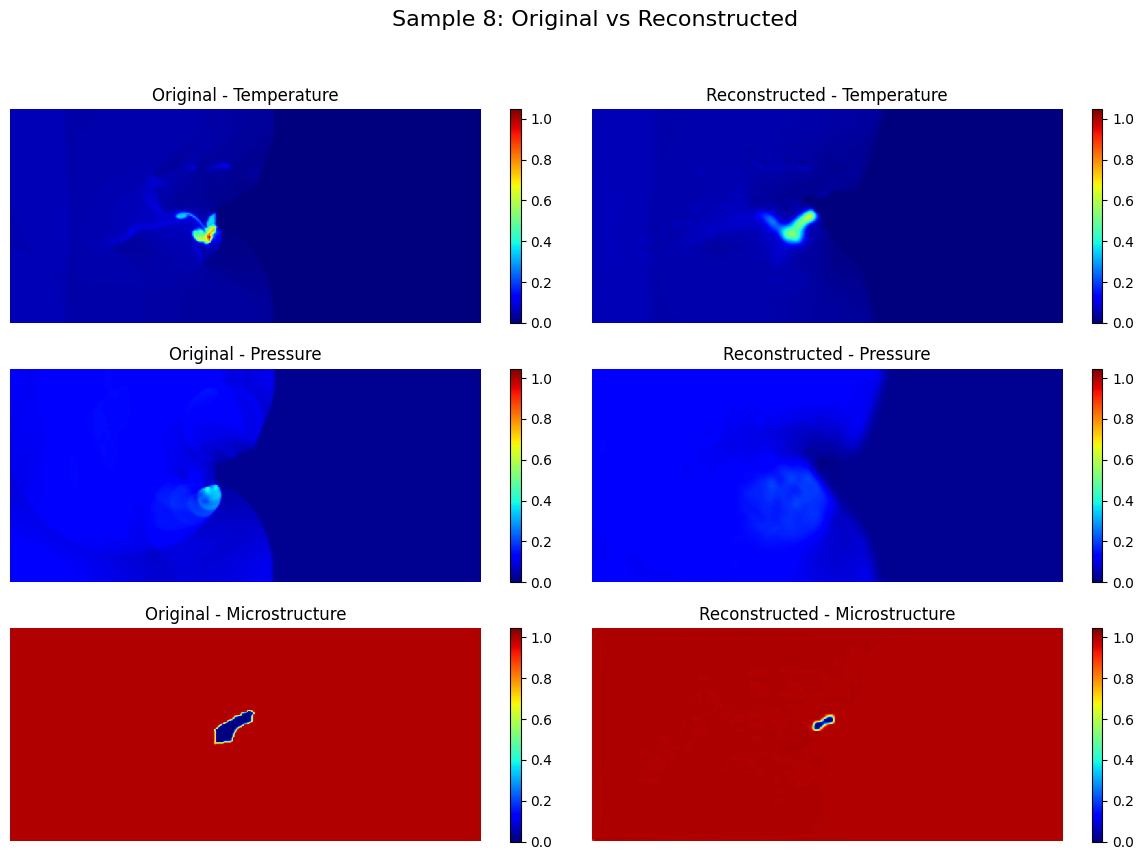

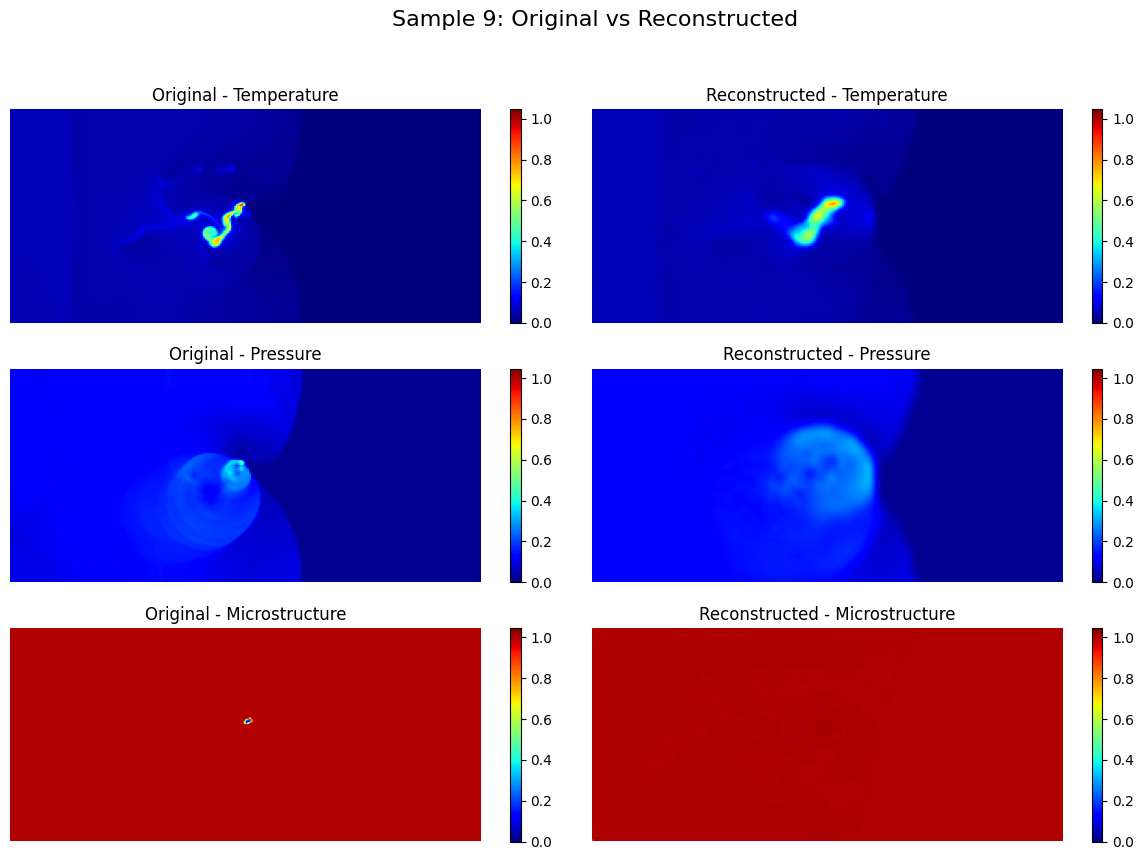

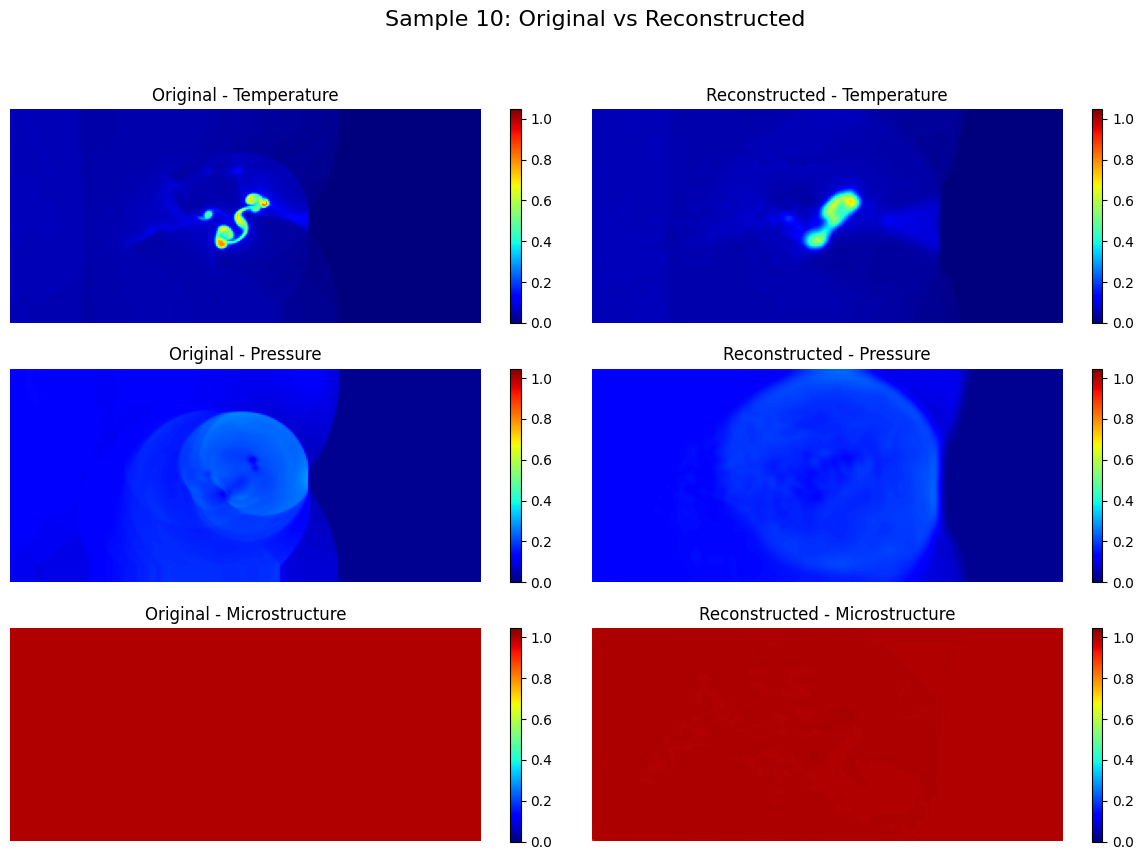

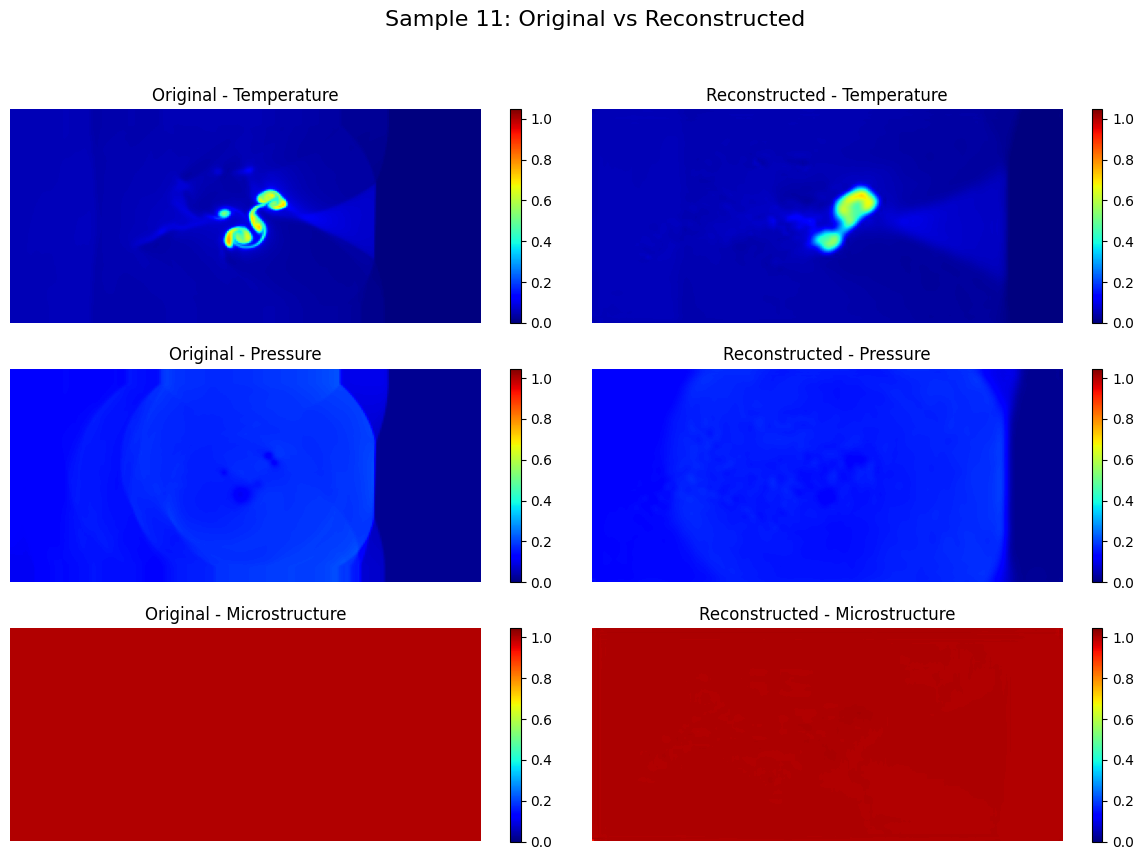

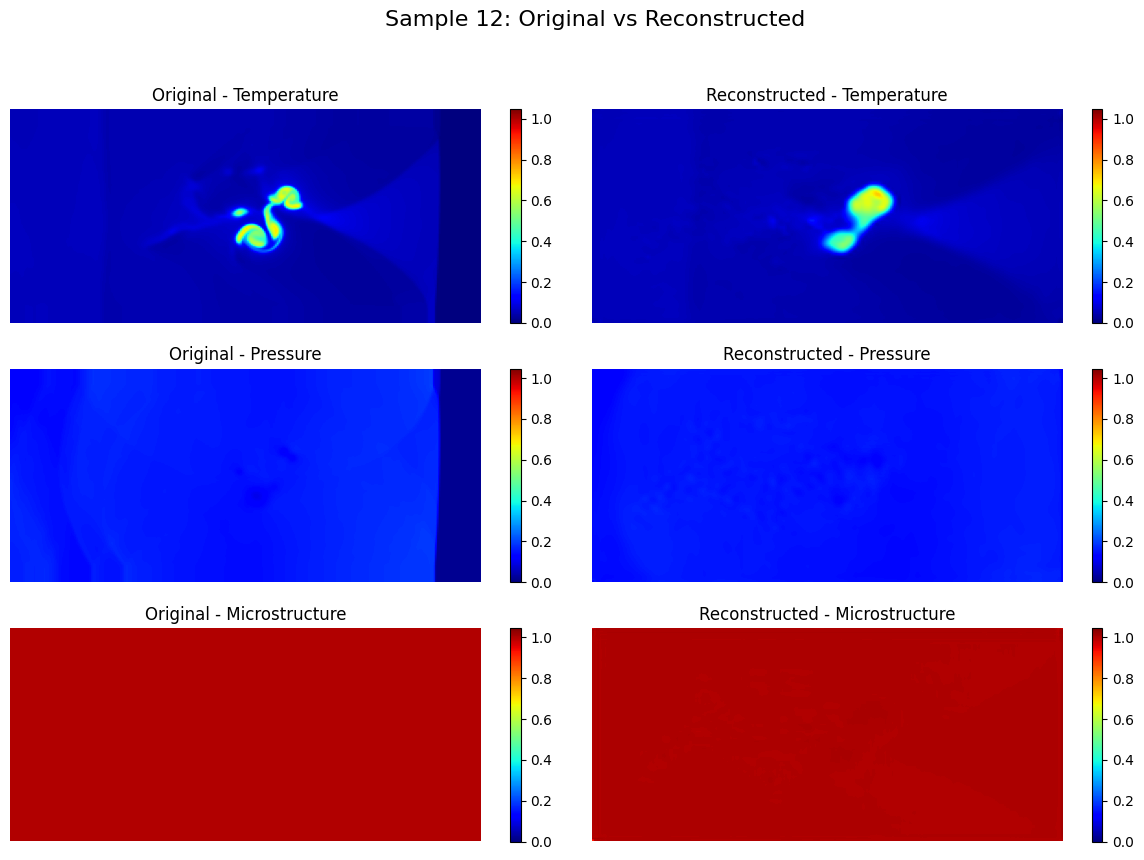

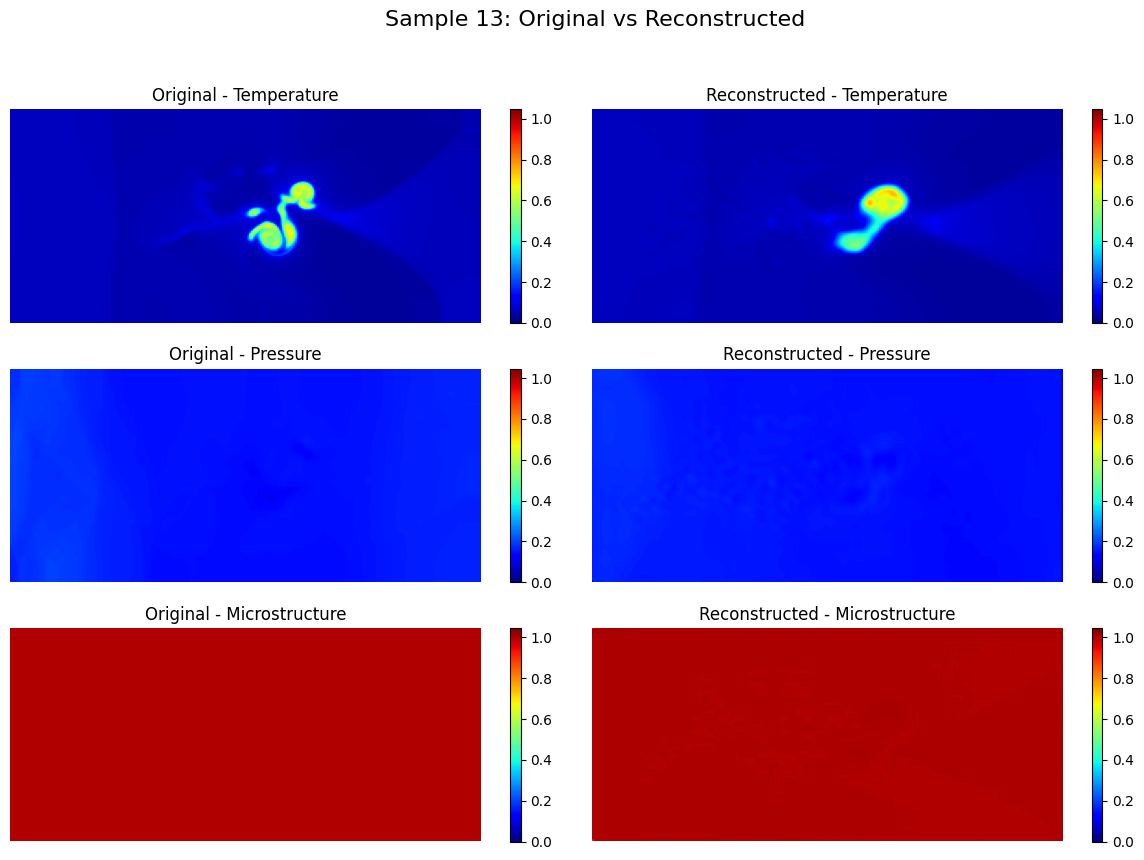

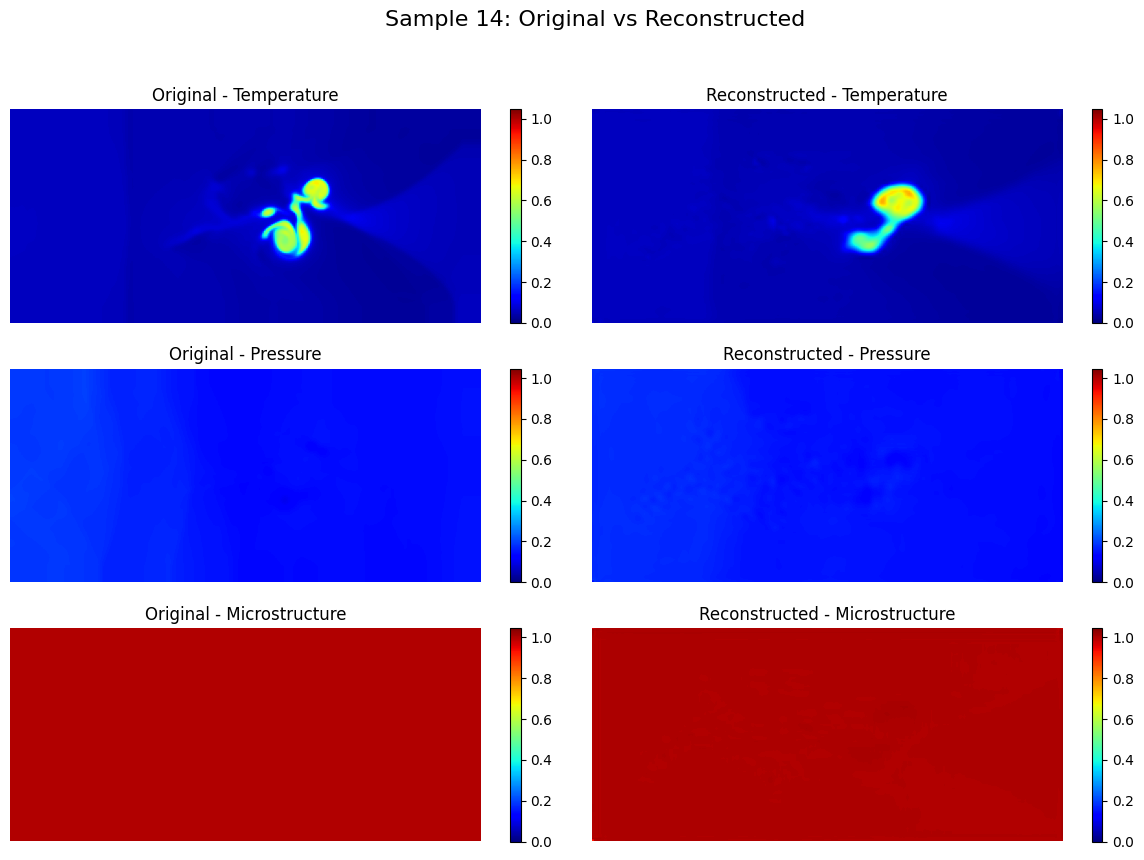

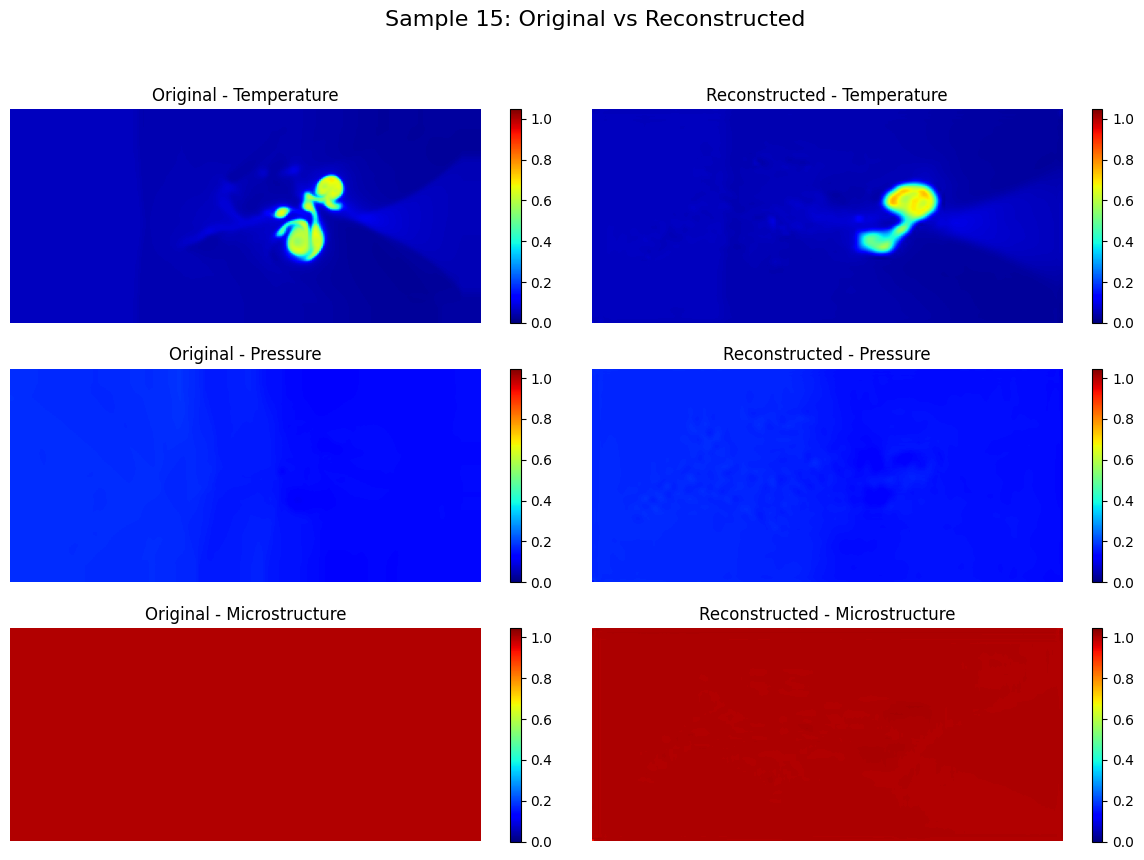

In [36]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

num_ts = 15 

visualize_reconstructions(
    X=X,
    reconstructions=decoded,
    channel_names=channel_names,
    num_ts=num_ts
)

### GIF

In [37]:
generate_prediction_comparison_gif(
    X=X,
    prediction=decoded,
    channel_names=["Temperature", "Pressure", "Microstructure"],
    file_name="TEST_1",
    plot_title="Rollout Prediction"
)

/tmp/ipykernel_74966/3807836999.py:141: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to TEST_1.gif


### z viz

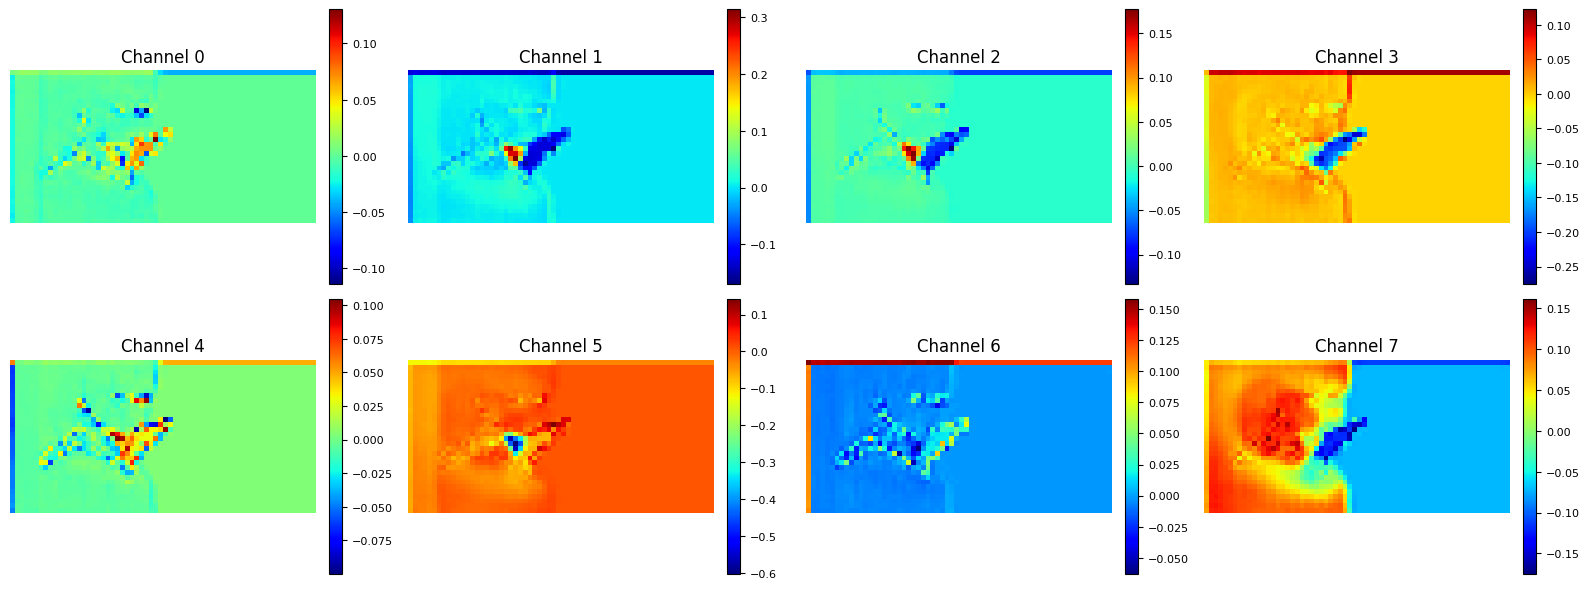

In [30]:
plot_latent_channels_grid(
    tensor=z,
    timestep=5,
    n_channels=8,
    grid_shape=(2, 4)
)

### GIF

In [16]:
generate_latent_gif(
    tensor=z,
    file_save_name="TEST_1",
    n_latent_channels=8,
    grid_shape=(2, 4),
    duration=500,
    loop=0
)

Per-channel vmin and vmax computed.
GIF saved as 'TEST_1.gif'


# Loss Plots

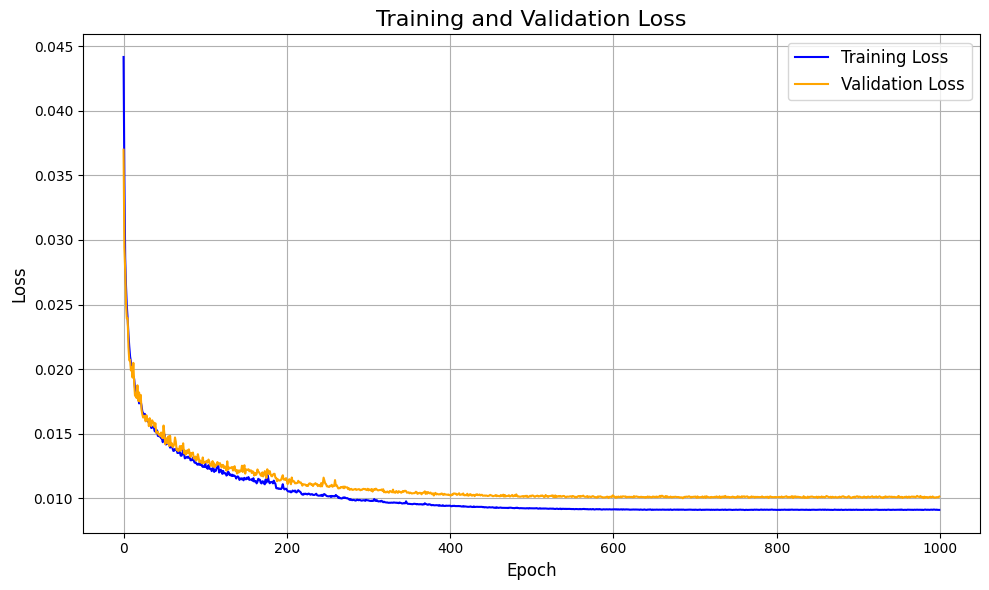

In [11]:
# Path to the JSON log file
log_file_path = "n_ts5_rollouttrain_layers_3_8_latent_8_NOpurpleloss_FROZEN_AE_original_DIFF_LP_LRplateau_pat10_e3_factor8_NONOISE_vertflips_1000.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

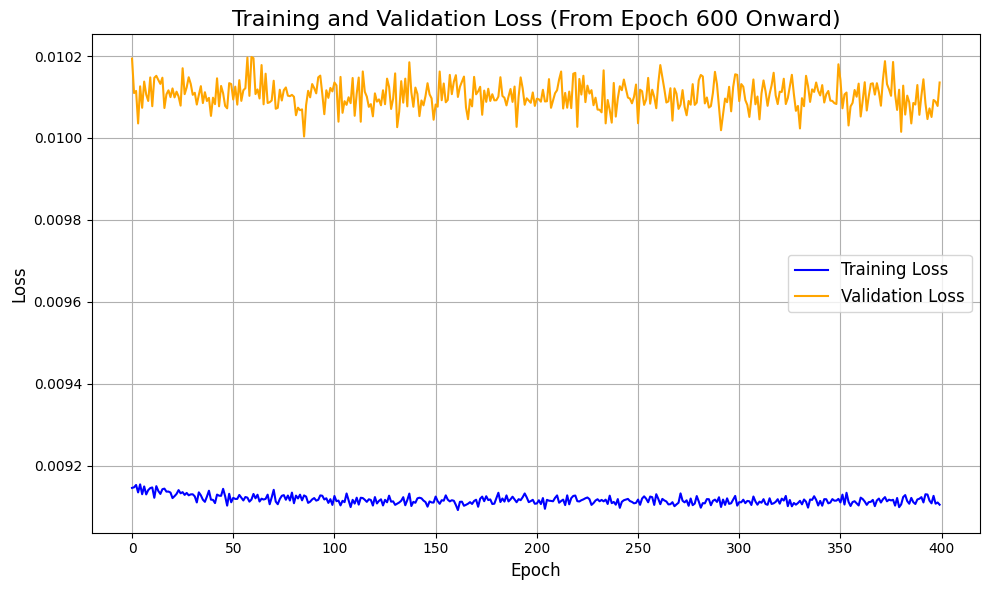

In [12]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 600

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title(f"Training and Validation Loss (From Epoch {start_epoch} Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


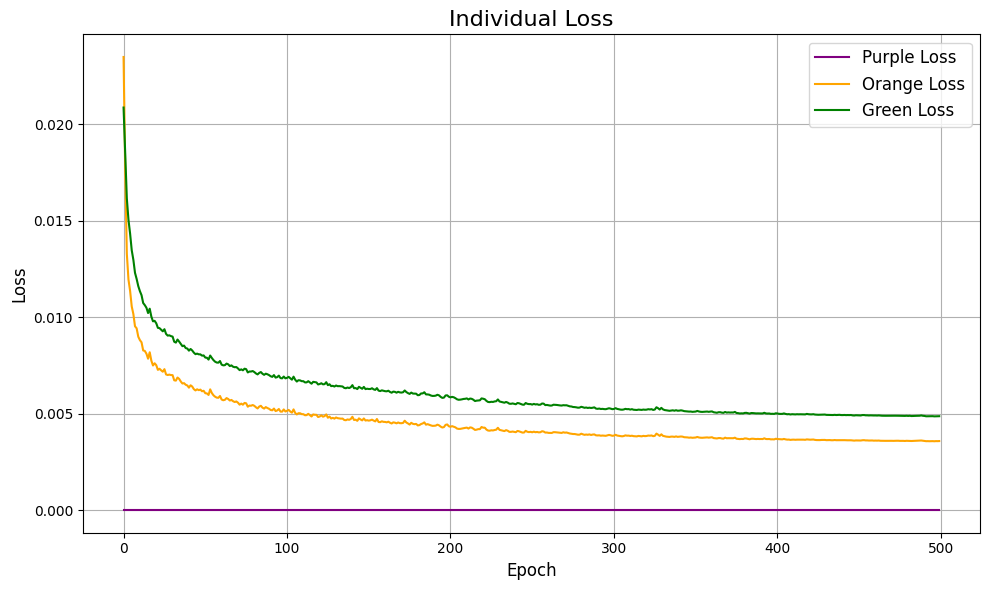

In [42]:
# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
purple_loss = log_dict['purple_loss_train']
orange_loss = log_dict['orange_loss_train']
green_loss = log_dict['green_loss_train']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(purple_loss, label="Purple Loss", color="purple")
ax.plot(orange_loss, label="Orange Loss", color="orange")
ax.plot(green_loss, label="Green Loss", color="green")

# Add titles, labels, and legend
ax.set_title("Individual Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Norm Comparison

Thoughts: Assessing how much information (time derivative - difference between timesteps) is preserved or compressed.

### STACKING ALL SAMPLES

In [5]:
# single ts predictions

n_samples = 33

# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

all_X = []
all_just_AE_reconstruction = []
all_just_AE_z = []
all_single_ts_Zhat = []
all_single_ts_full_reconstruction_pred = []

for i in range(n_samples):
    ic, _, ts, target = test_dataset[i]
    ic = ic[:n_channels, ...]
    target = target[:, :n_channels, ...]
 
    X = torch.concat((ic.unsqueeze(0), target))
    
    n_ts = 15

    just_AE_reconstruction = []
    just_AE_z = []
    single_ts_Zhat = []
    single_ts_full_reconstruction_pred = []

    for t in range(n_ts-1):
        IC = X[t, ...].unsqueeze(0).to(device)
        target = X[t+1, ...].unsqueeze(0).to(device)

        with torch.no_grad():
            # Reconstructing test images
            z_nodynamics, x_bar = model.network(IC, n_ts=0) # just AE
            z_hat, x_hat = model.network(IC, n_ts=1) # AE + dynamics

        # Sending reconstructed and original images to CPU and accumulating in lists
        just_AE_reconstruction.append(x_bar.cpu())
        just_AE_z.append(z_nodynamics.cpu())
        single_ts_Zhat.append(z_hat.cpu())
        single_ts_full_reconstruction_pred.append(x_hat.cpu())

    # Get last timestep for z_nodynamics
    z_nodynamics, x_bar = model.network(X[n_ts-1, ...].unsqueeze(0).to(device), n_ts=0) # just AE
    just_AE_reconstruction.append(x_bar.cpu())
    just_AE_z.append(z_nodynamics.cpu())

    # Concatenate all batches to create single tensors
    just_AE_reconstruction = torch.cat(just_AE_reconstruction, dim=0)
    just_AE_z = torch.cat(just_AE_z, dim=0)

    single_ts_Zhat = torch.cat(single_ts_Zhat, dim=0)  # Shape: (total_images, n_channels, height, width)
    single_ts_full_reconstruction_pred = torch.cat(single_ts_full_reconstruction_pred, dim=0)
    
    all_X.append(X)
    all_just_AE_reconstruction.append(just_AE_reconstruction)
    all_just_AE_z.append(just_AE_z)
    all_single_ts_Zhat.append(single_ts_Zhat)
    all_single_ts_full_reconstruction_pred.append(single_ts_full_reconstruction_pred)

all_X = torch.stack(all_X, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_just_AE_reconstruction = torch.stack(all_just_AE_reconstruction, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_just_AE_z = torch.stack(all_just_AE_z, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_single_ts_Zhat = torch.stack(all_single_ts_Zhat, dim=0)
all_single_ts_full_reconstruction_pred = torch.stack(all_single_ts_full_reconstruction_pred, dim=0)

2025-05-19 21:55:19,850 [INFO] Starting data validation...
2025-05-19 21:55:19,855 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 386.77it/s]
2025-05-19 21:55:19,946 [INFO] Data validation completed successfully.
2025-05-19 21:55:19,950 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 565.44it/s]
2025-05-19 21:55:20,012 [INFO] Total samples in dataset: 33


In [5]:
# rollout predictions
n_samples = 33

# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

all_X = []
all_z = []
all_decoded = []

for i in range(n_samples):
    ic, _, ts, target = test_dataset[i]
    ic = ic[:n_channels, ...]
    target = target[:, :n_channels, ...]

    X = torch.concat((ic.unsqueeze(0), target))
    
    with torch.no_grad():
        z, decoded = model_init(ic.unsqueeze(0).to(device), n_ts=n_ts, mode='pred')

    z = z.squeeze(1).cpu()
    decoded = decoded.squeeze(1).cpu()

    all_X.append(X)
    all_z.append(z)
    all_decoded.append(decoded)
    
all_X = torch.stack(all_X, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_z = torch.stack(all_z, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_decoded = torch.stack(all_decoded, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)


2025-05-29 22:14:59,195 [INFO] Starting data validation...
2025-05-29 22:14:59,197 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 706.85it/s]
2025-05-29 22:14:59,250 [INFO] Data validation completed successfully.
2025-05-29 22:14:59,251 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 819.09it/s]
2025-05-29 22:14:59,293 [INFO] Total samples in dataset: 33


NameError: name 'model_init' is not defined

In [ ]:
all_X.shape, all_z.shape, all_decoded.shape

### No Dynamics

In [4]:
all_input_norm, all_latent_norm, all_reconstruction_norm = [], [], []
all_separate_input_norm, all_separate_reconstruction_norm = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, ...])
    reconstruction_diff = compute_finite_difference(all_just_AE_reconstruction[i, ...])
    z_diff = compute_finite_difference(all_just_AE_z[i, ...])

    input_norm, latent_norm, reconstruction_norm = calculate_norm(X_diff, z_diff, reconstruction_diff)
    separate_input_norm, separate_reconstruction_norm = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_norm.append(input_norm)
    all_latent_norm.append(latent_norm)
    all_reconstruction_norm.append(reconstruction_norm)
    
    all_separate_input_norm.append(separate_input_norm)
    all_separate_reconstruction_norm.append(separate_reconstruction_norm)

NameError: name 'n_samples' is not defined

In [9]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_norm[i]) / np.array(all_input_norm[i])
    reconstruction_ratio = np.array(all_reconstruction_norm[i]) / np.array(all_input_norm[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

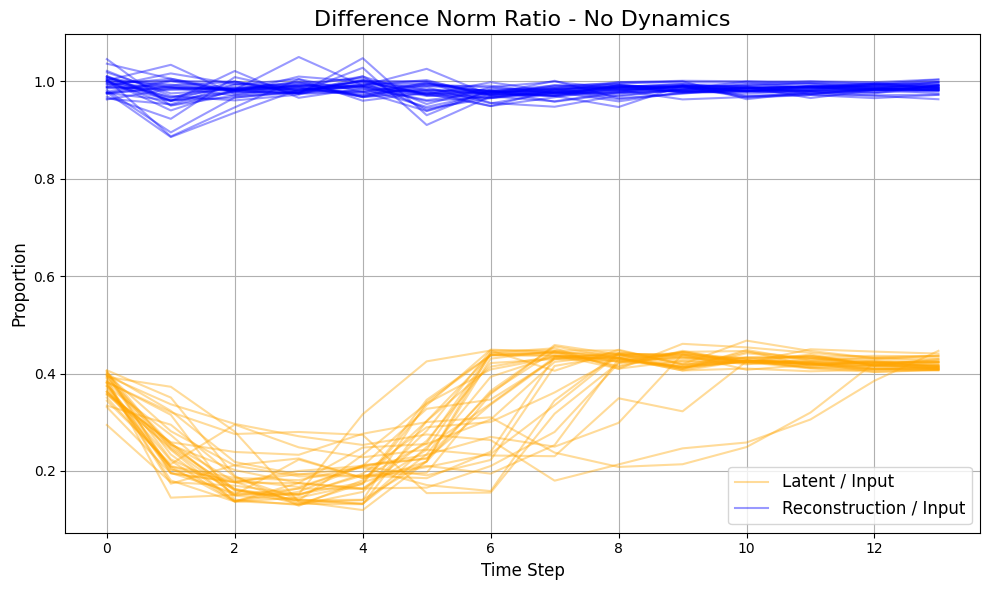

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [13]:
all_temp_ratio, all_pressure_ratio, all_ms_ratio = [], [], []

for i in range(n_samples):
    temp_ratio = all_separate_reconstruction_norm[i][:,0] / all_separate_input_norm[i][:,0]
    pressure_ratio = all_separate_reconstruction_norm[i][:,1] / all_separate_input_norm[i][:,1]
    # ms_ratio = separate_reconstruction_norm[:,2] / separate_input_norm[:,2]
    with np.errstate(divide='ignore', invalid='ignore'):
        ms_ratio = all_separate_reconstruction_norm[i][:,2] / all_separate_input_norm[i][:,2]
        ms_ratio[np.isnan(ms_ratio)] = 1.0  # replace only nan (e.g. 0/0) with 1
        ms_ratio[np.isinf(ms_ratio)] = 1.0  # optional: replace inf with 0
    
    all_temp_ratio.append(temp_ratio)
    all_pressure_ratio.append(pressure_ratio)
    all_ms_ratio.append(ms_ratio)

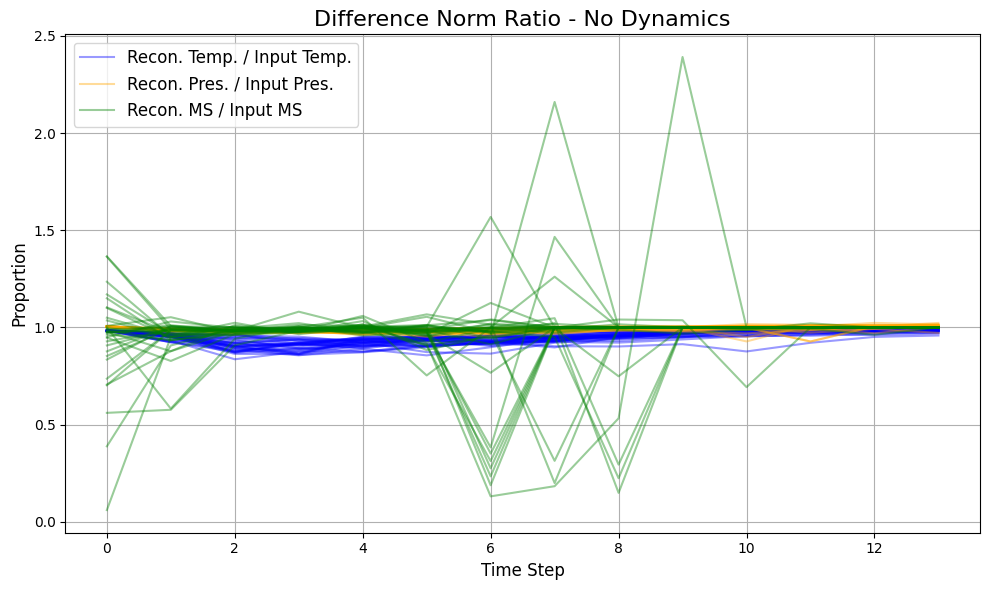

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

# can comment out any for loop to viz separate

# Plot all temperature ratios (blue, 60% transparent)
for i, temp in enumerate(all_temp_ratio):
    ax.plot(temp, color="blue", alpha=0.4, label="Recon. Temp. / Input Temp." if i == 0 else None)

# Plot all pressure ratios (orange, 60% transparent)
for i, pres in enumerate(all_pressure_ratio):
    ax.plot(pres, color="orange", alpha=0.4, label="Recon. Pres. / Input Pres." if i == 0 else None)

# Plot all MS ratios (green, 60% transparent)
for i, ms in enumerate(all_ms_ratio):
    ax.plot(ms, color="green", alpha=0.4, label="Recon. MS / Input MS" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [6]:
all_input_dot, all_latent_dot, all_reconstruction_dot = [], [], []
# all_separate_input_dot, all_separate_reconstruction_dot = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, ...])
    reconstruction_diff = compute_finite_difference(all_just_AE_reconstruction[i, ...])
    z_diff = compute_finite_difference(all_just_AE_z[i, ...])

    input_dot = compute_pairwise_dot_product(X_diff)
    latent_dot = compute_pairwise_dot_product(z_diff)
    reconstruction_dot = compute_pairwise_dot_product(reconstruction_diff)
    # separate_input_dot = compute_pairwise_dot_product(X_diff)
    # separate_reconstruction_dot = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_dot.append(input_dot)
    all_latent_dot.append(latent_dot)
    all_reconstruction_dot.append(reconstruction_dot)
    
    # all_separate_input_norm.append(separate_input_norm)
    # all_separate_reconstruction_norm.append(separate_reconstruction_norm)

In [7]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_dot[i]) / np.array(all_input_dot[i])
    reconstruction_ratio = np.array(all_reconstruction_dot[i]) / np.array(all_input_dot[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

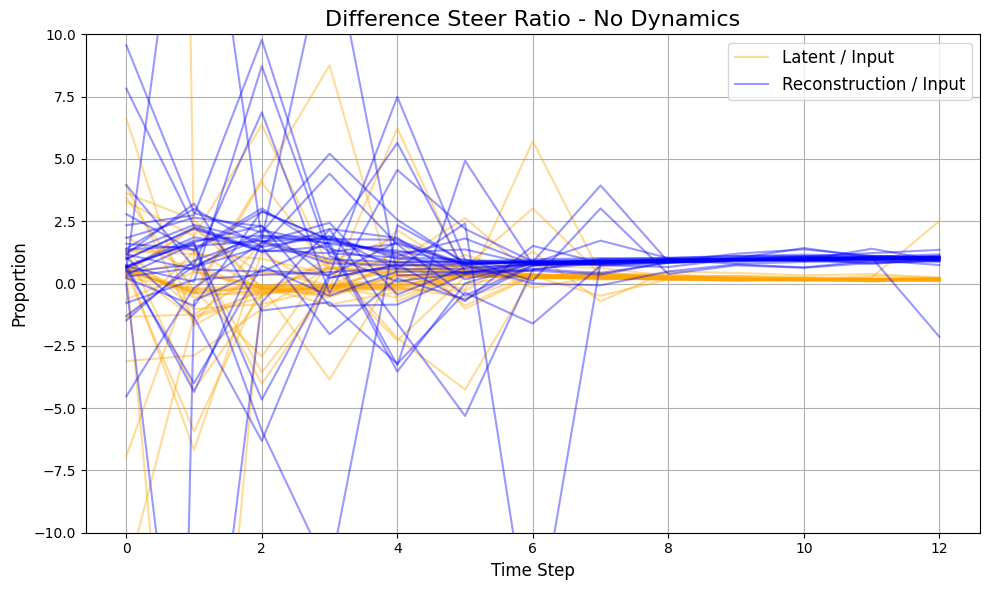

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Steer Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

ax.set_ylim(-10, 10)  # Adjust range to focus on relevant data (change 0 and 2 as needed)

plt.tight_layout()
plt.show()


### Single TS Pred

In [15]:
all_input_norm, all_latent_norm, all_reconstruction_norm = [], [], []
all_separate_input_norm, all_separate_reconstruction_norm = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, 1:, ...])
    reconstruction_diff = compute_finite_difference(all_single_ts_full_reconstruction_pred[i, ...])
    z_diff = compute_finite_difference(all_single_ts_Zhat[i, ...])

    input_norm, latent_norm, reconstruction_norm = calculate_norm(X_diff, z_diff, reconstruction_diff)
    separate_input_norm, separate_reconstruction_norm = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_norm.append(input_norm)
    all_latent_norm.append(latent_norm)
    all_reconstruction_norm.append(reconstruction_norm)
    
    all_separate_input_norm.append(separate_input_norm)
    all_separate_reconstruction_norm.append(separate_reconstruction_norm)


In [16]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_norm[i]) / np.array(all_input_norm[i])
    reconstruction_ratio = np.array(all_reconstruction_norm[i]) / np.array(all_input_norm[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

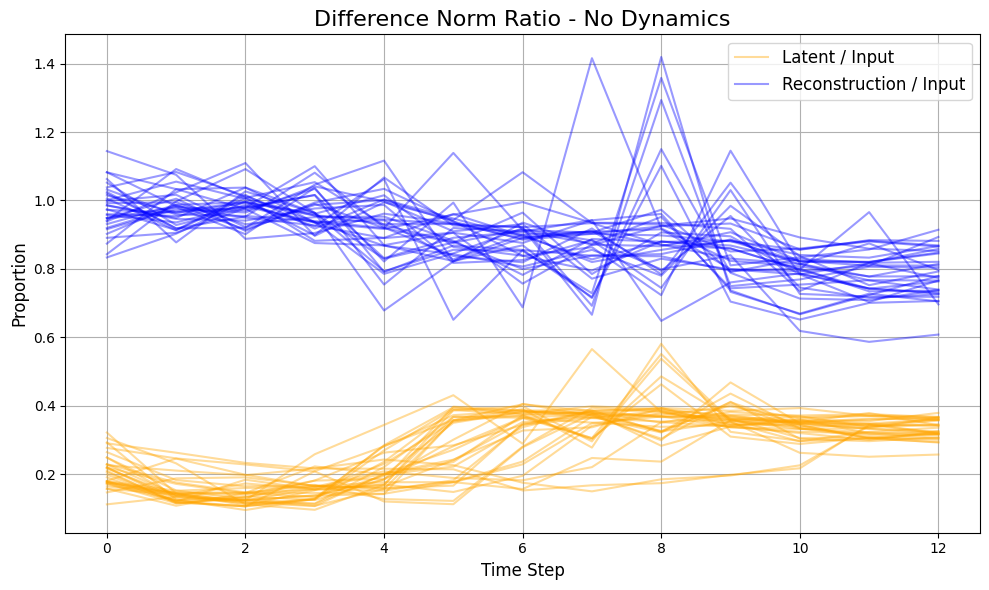

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [18]:
all_temp_ratio, all_pressure_ratio, all_ms_ratio = [], [], []

for i in range(n_samples):
    temp_ratio = all_separate_reconstruction_norm[i][:,0] / all_separate_input_norm[i][:,0]
    pressure_ratio = all_separate_reconstruction_norm[i][:,1] / all_separate_input_norm[i][:,1]
    # ms_ratio = separate_reconstruction_norm[:,2] / separate_input_norm[:,2]
    with np.errstate(divide='ignore', invalid='ignore'):
        ms_ratio = all_separate_reconstruction_norm[i][:,2] / all_separate_input_norm[i][:,2]
        ms_ratio[np.isnan(ms_ratio)] = 1.0  # replace only nan (e.g. 0/0) with 1
        ms_ratio[np.isinf(ms_ratio)] = 1.0  # optional: replace inf with 0
    
    all_temp_ratio.append(temp_ratio)
    all_pressure_ratio.append(pressure_ratio)
    all_ms_ratio.append(ms_ratio)

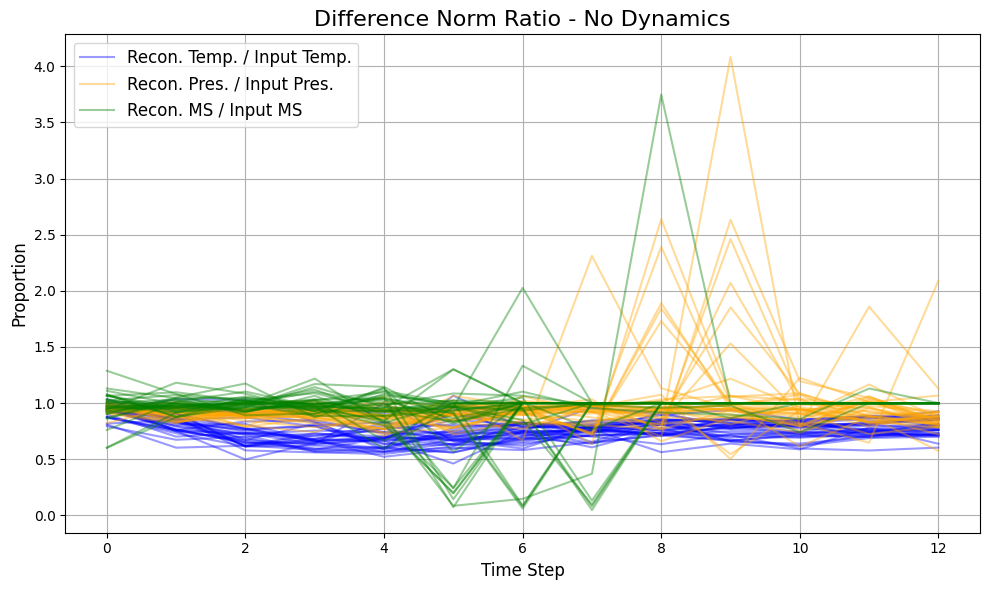

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

# can comment out any for loop to viz separate

# Plot all temperature ratios (blue, 60% transparent)
for i, temp in enumerate(all_temp_ratio):
    ax.plot(temp, color="blue", alpha=0.4, label="Recon. Temp. / Input Temp." if i == 0 else None)

# Plot all pressure ratios (orange, 60% transparent)
for i, pres in enumerate(all_pressure_ratio):
    ax.plot(pres, color="orange", alpha=0.4, label="Recon. Pres. / Input Pres." if i == 0 else None)

# Plot all MS ratios (green, 60% transparent)
for i, ms in enumerate(all_ms_ratio):
    ax.plot(ms, color="green", alpha=0.4, label="Recon. MS / Input MS" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


### Rollout Prediction

In [7]:
all_input_norm, all_latent_norm, all_reconstruction_norm = [], [], []
all_separate_input_norm, all_separate_reconstruction_norm = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, ...])
    z_diff = compute_finite_difference(all_z[i, ...])
    reconstruction_diff = compute_finite_difference(all_decoded[i, ...])

    input_norm, latent_norm, reconstruction_norm = calculate_norm(X_diff, z_diff, reconstruction_diff)
    separate_input_norm, separate_reconstruction_norm = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_norm.append(input_norm)
    all_latent_norm.append(latent_norm)
    all_reconstruction_norm.append(reconstruction_norm)
    
    all_separate_input_norm.append(separate_input_norm)
    all_separate_reconstruction_norm.append(separate_reconstruction_norm)

In [8]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_norm[i]) / np.array(all_input_norm[i])
    reconstruction_ratio = np.array(all_reconstruction_norm[i]) / np.array(all_input_norm[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

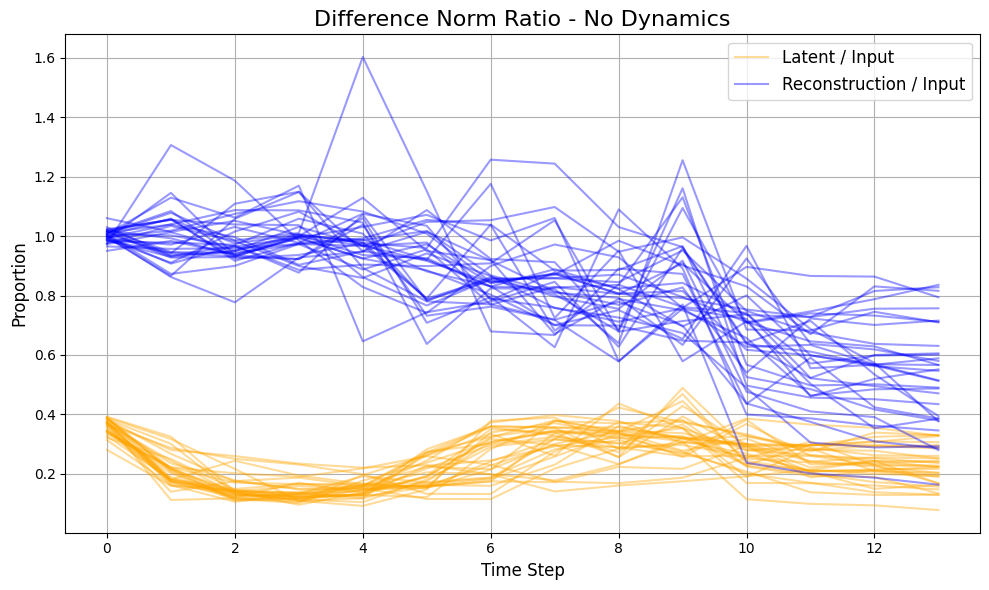

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [10]:
all_temp_ratio, all_pressure_ratio, all_ms_ratio = [], [], []

for i in range(n_samples):
    temp_ratio = all_separate_reconstruction_norm[i][:,0] / all_separate_input_norm[i][:,0]
    pressure_ratio = all_separate_reconstruction_norm[i][:,1] / all_separate_input_norm[i][:,1]
    # ms_ratio = separate_reconstruction_norm[:,2] / separate_input_norm[:,2]
    with np.errstate(divide='ignore', invalid='ignore'):
        ms_ratio = all_separate_reconstruction_norm[i][:,2] / all_separate_input_norm[i][:,2]
        ms_ratio[np.isnan(ms_ratio)] = 1.0  # replace only nan (e.g. 0/0) with 1
        ms_ratio[np.isinf(ms_ratio)] = 1.0  # optional: replace inf with 0
    
    all_temp_ratio.append(temp_ratio)
    all_pressure_ratio.append(pressure_ratio)
    all_ms_ratio.append(ms_ratio)

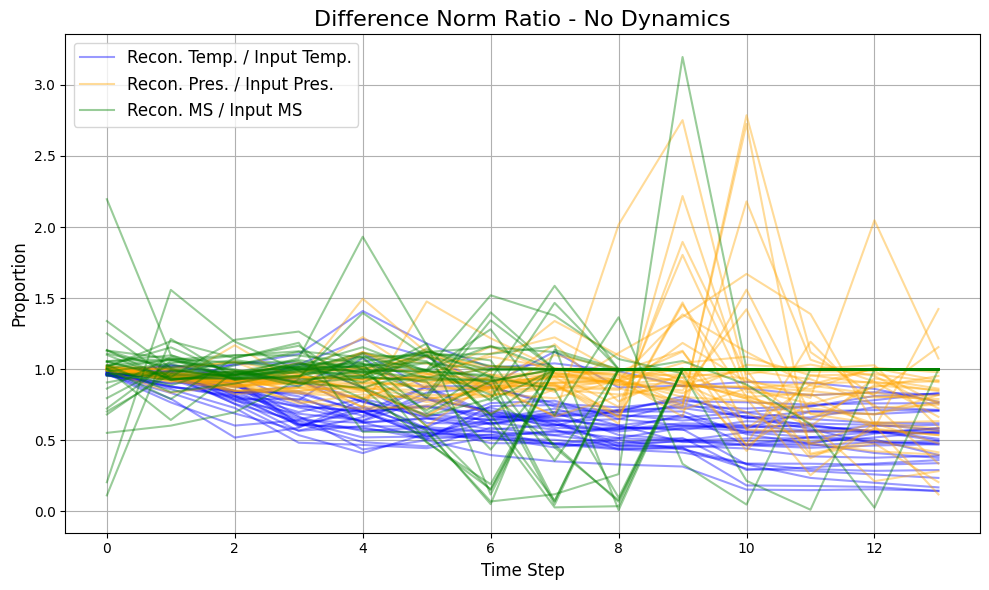

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# can comment out any for loop to viz separate

# Plot all temperature ratios (blue, 60% transparent)
for i, temp in enumerate(all_temp_ratio):
    ax.plot(temp, color="blue", alpha=0.4, label="Recon. Temp. / Input Temp." if i == 0 else None)

# Plot all pressure ratios (orange, 60% transparent)
for i, pres in enumerate(all_pressure_ratio):
    ax.plot(pres, color="orange", alpha=0.4, label="Recon. Pres. / Input Pres." if i == 0 else None)

# Plot all MS ratios (green, 60% transparent)
for i, ms in enumerate(all_ms_ratio):
    ax.plot(ms, color="green", alpha=0.4, label="Recon. MS / Input MS" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()
